# Test Methods

In [1]:
import pickle
with open('ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

In [2]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho'][:]
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho'][:]
lat_rho = np.transpose(lat_rho, axes=(1, 0))
f  = dataset.variables['f'][:]
f = np.transpose(f, axes=(1, 0))
h = dataset.variables['h'][:]
h = np.transpose(h, axes=(1, 0))
z_r = np.load('/home/z5297792/UNSW-MRes/MRes/z_r/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
temp_ave = np.load('/srv/scratch/z5297792/Climatology/temp_ave.npy')
CurSpeed_ave = np.load('/srv/scratch/z5297792/Climatology/CurSpeed_ave.npy')


In [3]:
import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None

def grid_finder(i_search, j_search, SEARCH_WIDTH):
    fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
    dataset = nc.Dataset(fname)
    lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
    lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
    
    def within_search_width(i_offset, j_offset):
        return distance(lat_rho[i_search, j_search], lon_rho[i_search, j_search],
                        lat_rho[i_search + i_offset, j_search + j_offset], 
                        lon_rho[i_search + i_offset, j_search + j_offset]) < SEARCH_WIDTH / 2

    i_left, i_right = 0, 0
    j_down, j_up = 0, 0

    while i_search - i_left >= 0 and within_search_width(-i_left, 0):
        i_left += 1
    while i_search + i_right < lon_rho.shape[0] and within_search_width(i_right, 0):
        i_right += 1
    while j_search - j_down >= 0 and within_search_width(0, -j_down):
        j_down += 1
    while j_search + j_up < lon_rho.shape[1] and within_search_width(0, j_up):
        j_up += 1

    i_left = max(i_search - i_left + 1, 0)
    i_right = min(i_search + i_right, lon_rho.shape[0])
    j_down = max(j_search - j_down + 1, 0)
    j_up = min(j_search + j_up, lon_rho.shape[1])

    return i_left, i_right, j_down, j_up

def eddies_nearest_rho(elon, elat):
    dataset = nc.Dataset('/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc')
    lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
    lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
    R = np.sqrt((lon_rho - elon)**2 + (lat_rho - elat)**2)
    i_search, j_search = np.unravel_index(np.argmin(R), R.shape)
    return i_search, j_search

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357000
    lat1_rad, lon1_rad = np.radians(lat1), np.radians(lon1)
    lat2_rad, lon2_rad = np.radians(lat2), np.radians(lon2)
    dlat, dlon = lat2_rad - lat1_rad, lon2_rad - lon1_rad
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

def find_global_maxima(matrix):
    i_max, j_max = np.unravel_index(np.argmax(matrix, axis=None), matrix.shape)
    return i_max, j_max

def eddies_nearest_rho(elon, elat):
    dataset = nc.Dataset('/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc')
    lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
    lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
    R = np.sqrt((lon_rho - elon)**2 + (lat_rho - elat)**2)
    i_search, j_search = np.unravel_index(np.argmin(R), R.shape)
    return i_search, j_search

def get_variable_name(var):
    for name, value in globals().items():
        if value is var:
            split_name = re.sub(r'([a-z])([A-Z])', r'\1 \2', name)
            split_name = re.sub(r'\d+', '', split_name)  # Remove digits
            return split_name
    return None

def make_cartesian(lon, lat, theta0, phi0):
    lonr, latr = np.deg2rad(lon), np.deg2rad(lat)
    r_earth = 6371
    x = r_earth * np.cos(np.deg2rad(phi0)) * (lonr - np.deg2rad(theta0))
    y = r_earth * (latr - np.deg2rad(phi0))
    return x, y

def eddy_centric_grid_distances(i_search, j_search, i_left, i_right, j_down, j_up):
    lonc = lon_rho[i_search, j_search]
    latc = lat_rho[i_search, j_search]
    def make_left_values_negative(arr):
        zero_index = np.where(arr == 0)[0]
        if zero_index.size == 0:
            return arr
        zero_index = zero_index[0]
        arr[:zero_index] = -np.abs(arr[:zero_index])
        return arr
    x = make_left_values_negative(distance(latc, lonc, lat_rho[i_left:i_right,j_search], lon_rho[i_left:i_right,j_search]))
    y = make_left_values_negative(distance(latc, lonc, lat_rho[i_search,j_down:j_up], lon_rho[i_search,j_down:j_up]))
    return x.data/1000, y.data/1000

def rotate_20_clockwise(x, y):
    theta = np.deg2rad(20)
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    points = np.vstack((x, y))
    rotated_points = rotation_matrix @ points
    x_rotated, y_rotated = rotated_points
    return x_rotated, y_rotated

def extract_contour(level_to_extract, plot):
    for level_paths in plot.allsegs:
        for path in level_paths:
            xt = path[:, 0]
            yt = path[:, 1]
            return xt, yt
    else:
        return [], []

def process_eddy_data(sample_data, eddy, z_r, depth_lvl_limit, method):
    # Initialize empty DataFrames
    x_df = pd.DataFrame()
    y_df = pd.DataFrame()
    x_diff_df = pd.DataFrame()
    y_diff_df = pd.DataFrame()
    TD_df = pd.DataFrame()
    D_df = pd.DataFrame()

    # Loop over the time data for the given eddy
    for i, time_data in enumerate(sample_data[eddy][method].values()):
        # Process x values
        x = time_data['x'] - time_data.iloc[0]['x']
        if len(x) < depth_lvl_limit:
            nans_to_add = max(0, depth_lvl_limit - len(x))
            x = pd.concat([x, pd.Series([np.nan] * nans_to_add)], ignore_index=True)
        x_df['x'+str(i)] = x
        x_diff_df['x'+str(i)] = x.diff() / np.insert(np.diff(-z_r), 0, np.nan)

        # Process y values
        y = time_data['y'] - time_data.iloc[0]['y']
        if len(y) < depth_lvl_limit:
            nans_to_add = max(0, depth_lvl_limit - len(y))
            y = pd.concat([y, pd.Series([np.nan] * nans_to_add)], ignore_index=True)
        y_df['y'+str(i)] = y
        y_diff_df['y'+str(i)] = y.diff() / np.insert(np.diff(-z_r), 0, np.nan)

        # Calculate total distance (TD) and distance between adjacent points (D)
        TD_df['TD'+str(i)] = np.sqrt(x**2 + y**2)
        D_df['D'+str(i)] = np.sqrt(x.diff()**2 + y.diff()**2) / np.insert(np.diff(-z_r), 0, np.nan)

    # Add mean, std dev, and depth info to the DataFrames
    for df, diff_df, axis_label in [(x_df, x_diff_df, 'x'), (y_df, y_diff_df, 'y'), (TD_df, TD_df, 'TD'), (D_df, D_df, 'D')]:

        mean = df.mean(axis=1)
        std = df.std(axis=1)

        mean_diff = diff_df.mean(axis=1)
        std_diff = diff_df.std(axis=1)

        df['Depth'] = z_r * 1000
        diff_df['Depth'] = z_r * 1000

        df['Mean'] = mean
        df['StdDev'] = std

        diff_df['Mean'] = mean_diff
        diff_df['StdDev'] = std_diff


    return x_df, y_df, x_diff_df, y_diff_df, TD_df, D_df


# Gathering Our Sample

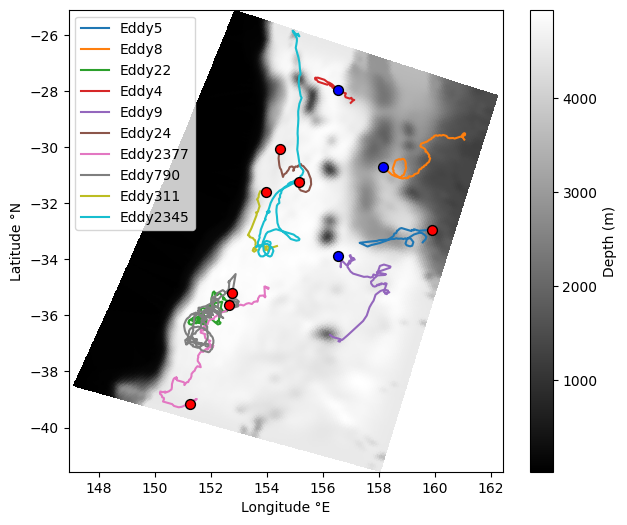

In [4]:
sample_eddies = ['Eddy5', 'Eddy8', 'Eddy22', 'Eddy4', 'Eddy9', 'Eddy24', 'Eddy2377', 'Eddy790', 'Eddy311', 'Eddy2345']

colors = plt.get_cmap('tab10')

plt.figure(figsize=(7, 6))

plt.pcolormesh(lon_rho, lat_rho, h, shading='auto', cmap='gray')
plt.colorbar(label='Depth (m)')
plt.xlabel('Longitude °E')
plt.ylabel('Latitude °N')

for i, e in enumerate(sample_eddies):
    eddy_data = eddies[e]
    
    plt.plot(eddy_data['Lon'], eddy_data['Lat'], color=colors(i), label=e)
    
    plt.scatter(eddy_data['Lon'].iloc[-1], eddy_data['Lat'].iloc[-1], color='r' if eddy_data['Vort'].iloc[-1] > 0 else 'b', edgecolor='black', s=50, zorder=5)

# plt.xlim([148, 161])
plt.axis('equal')

plt.legend(loc='upper left')
plt.show()


In [5]:
# with open('/srv/scratch/z5297792/Sample/sample_data_AE22.pkl', 'rb') as file:
#     sample_data = pickle.load(file)

In [6]:
# sample_data.keys()

In [8]:
# AE5T10 AE83T6 AE22T45/10 CE4T45/10 CE9T45 ACE24

sample_data = {}
# for sample_eddy in ['Eddy9', 'Eddy2377', 'Eddy22', 'Eddy8', 'Eddy311', 'Eddy4' ]:
for sample_eddy in ['Eddy8']:

    edata = eddies[sample_eddy] 

    # Extract entire lifetime
    # t0 = extract_number(edata.iloc[0].name) 
    # tN = extract_number(edata.iloc[-1].name)

    # Extract the middle 30 days
    middle_index = edata.shape[0] // 2
    t0 = extract_number(edata.iloc[middle_index - 15].name) 
    tN = extract_number(edata.iloc[middle_index + 15].name) 
    
    # Initialize arrays
    U1 = np.zeros((lon_rho.shape[0], lon_rho.shape[1], z_r.shape[-1], tN - t0))
    V1 = np.zeros_like(U1)
    TemperatureAnomaly1 = np.zeros_like(U1)
    CurSpeed1 = np.zeros_like(U1)
    OW1 = np.zeros_like(U1)
    
    # Calculate time moduli
    t_mod0 = t0 % 30
    t_modN = tN % 30
    file_idx0 = int(t0 // 30)
    file_idxN = int(tN // 30)
    
    # Loop through the files as needed
    for file_idx in range(file_idx0, file_idxN + 1):
        fnumber = str(f"{round(1461 + file_idx * 30):05d}")
        fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_' + fnumber + '.nc'
        
        if file_idx == file_idx0:
            t_pres = 30 - t_mod0
            start_idx = t_mod0
            end_idx = 30 if file_idx != file_idxN else t_modN
        elif file_idx == file_idxN:
            start_idx = 0
            end_idx = t_modN
        else:
            start_idx = 0
            end_idx = 30
    
        # Load the data from the file
        U_chunk = np.load(f'/srv/scratch/z5297792/Climatology/u_v/u_{fnumber}.npy')[:, :, :, start_idx:end_idx]
        V_chunk = np.load(f'/srv/scratch/z5297792/Climatology/u_v/v_{fnumber}.npy')[:, :, :, start_idx:end_idx]
        Temp_chunk = np.load(f'/srv/scratch/z5297792/Climatology/temps/temp_{fnumber}.npy')[:, :, :, start_idx:end_idx] - temp_ave[:, :, :, np.newaxis]
        CurSpeed_chunk = np.load(f'/srv/scratch/z5297792/Climatology/ow_and_cur_speeds/cur_speed_{fnumber}.npy')[:, :, :, start_idx:end_idx]
        OW_chunk = np.load(f'/srv/scratch/z5297792/Climatology/ow_and_cur_speeds/ow_{fnumber}.npy')[:, :, :, start_idx:end_idx]
        
        # Fill the data in the relevant arrays
        if file_idx == file_idx0:
            U1[:, :, :, :t_pres] = U_chunk
            V1[:, :, :, :t_pres] = V_chunk
            TemperatureAnomaly1[:, :, :, :t_pres] = Temp_chunk
            CurSpeed1[:, :, :, :t_pres] = CurSpeed_chunk
            OW1[:, :, :, :t_pres] = OW_chunk
        elif file_idx == file_idxN:
            U1[:, :, :, t_pres:] = U_chunk
            V1[:, :, :, t_pres:] = V_chunk
            TemperatureAnomaly1[:, :, :, t_pres:] = Temp_chunk
            CurSpeed1[:, :, :, t_pres:] = CurSpeed_chunk
            OW1[:, :, :, t_pres:] = OW_chunk
        else:
            U1[:, :, :, t_pres:(t_pres + 30)] = U_chunk
            V1[:, :, :, t_pres:(t_pres + 30)] = V_chunk
            TemperatureAnomaly1[:, :, :, t_pres:(t_pres + 30)] = Temp_chunk
            CurSpeed1[:, :, :, t_pres:(t_pres + 30)] = CurSpeed_chunk
            OW1[:, :, :, t_pres:(t_pres + 30)] = OW_chunk
            t_pres += 30

    del U_chunk, V_chunk, Temp_chunk, CurSpeed_chunk, OW_chunk
    
    U1 = np.where(abs(U1) > 1e30, np.nan, U1)
    V1 = np.where(abs(V1) > 1e30, np.nan, V1)
    TemperatureAnomaly1 = np.where(abs(TemperatureAnomaly1) > 1e30, np.nan, TemperatureAnomaly1) 
    CurSpeed1 = np.where(abs(CurSpeed1) > 1e30, np.nan, CurSpeed1) 

    sample_data[sample_eddy] = {
        'U': U1,
        'V': V1,
        'TA': TemperatureAnomaly1,
        'CS': CurSpeed1,
        'OW': OW1
    }
    print(sample_eddy)

with open('/srv/scratch/z5297792/Sample/sample_data_CE8.pkl', 'wb') as file:
    pickle.dump(sample_data, file)

Eddy8


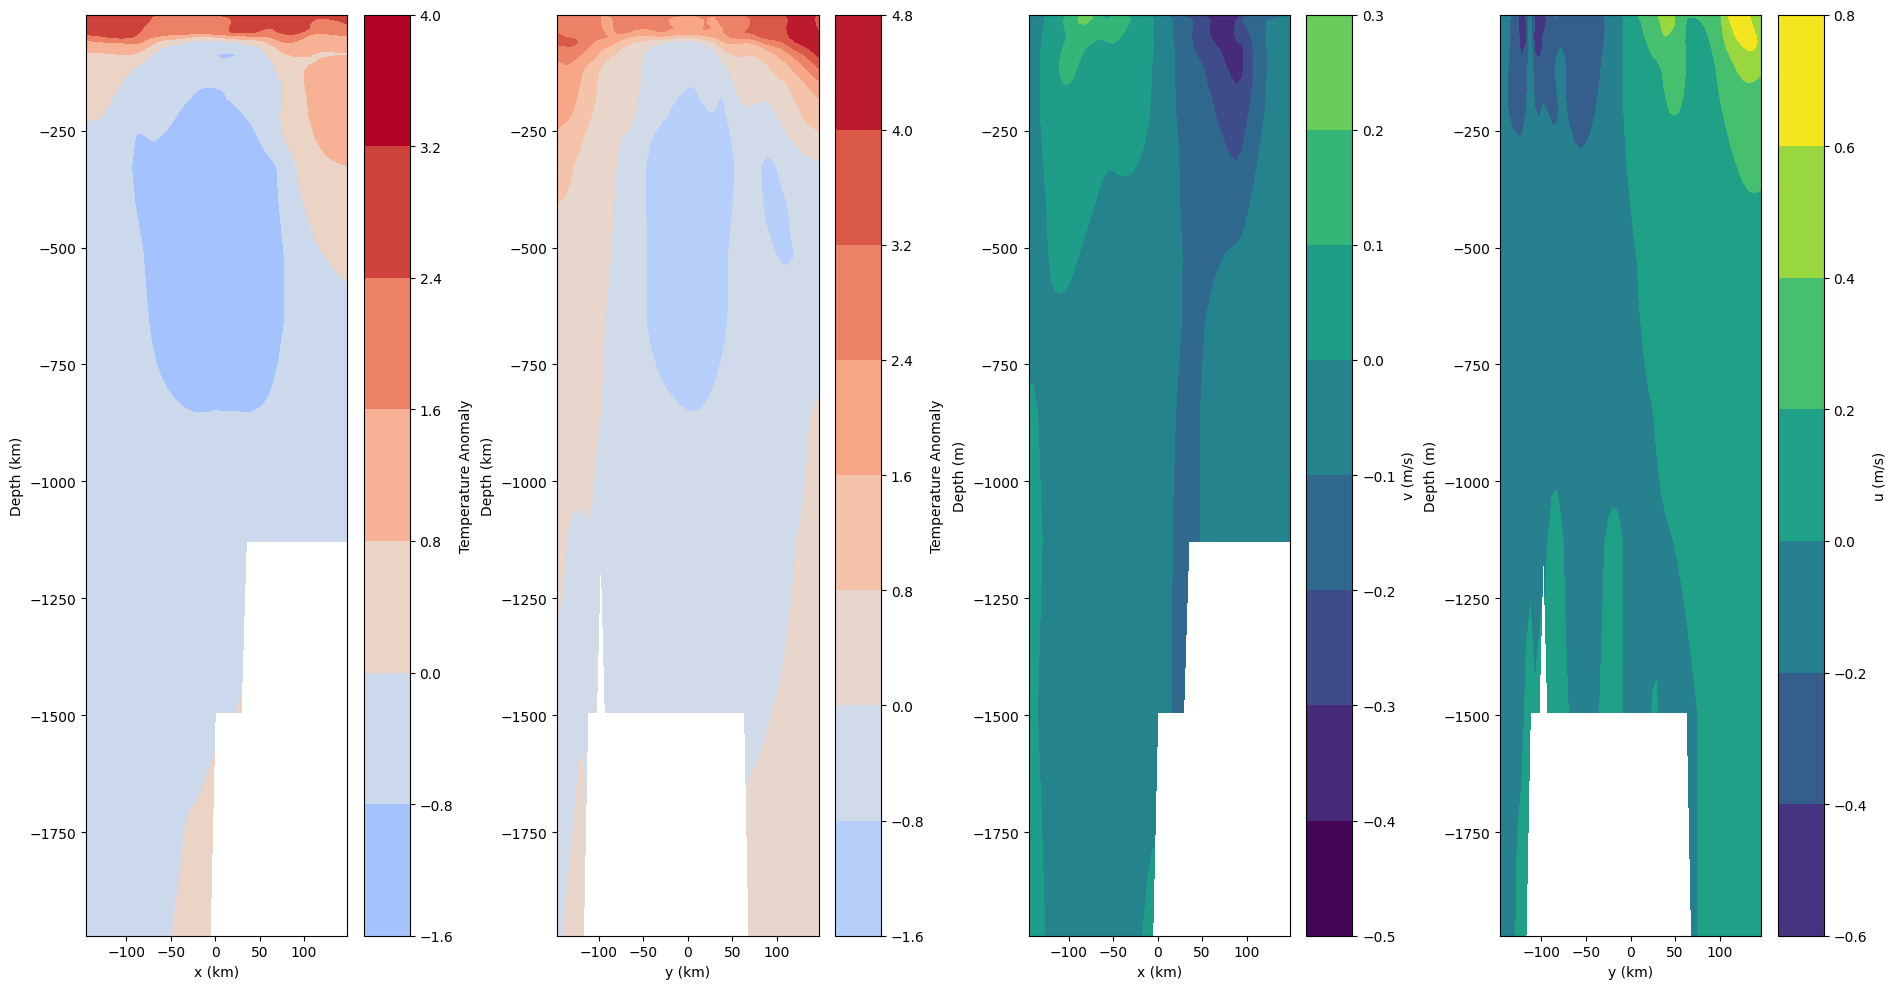

In [9]:
import matplotlib.colors as mcolors

DISPLAY_WIDTH = 300000
DEPTH_LVL_LIMIT = 25

eddy = 'Eddy8'

U = sample_data[eddy]['U']
V = sample_data[eddy]['V']
TA = sample_data[eddy]['TA']

t = TA.shape[-1] // 2

t0 = eddies[eddy].shape[0] // 2 - 15

t_eddy_relative = t + t0

DataField = TA

DataField_name = get_variable_name(DataField)
DataField = np.squeeze(DataField[:, :, :, t])
DataField = np.where(abs(DataField) > 1e30, np.nan, DataField)

i_search, j_search = eddies_nearest_rho(eddies[eddy].iloc[t_eddy_relative].Lon, eddies[eddy].iloc[t_eddy_relative].Lat)

i_left, i_right, j_down, j_up = grid_finder(i_search, j_search, DISPLAY_WIDTH)
x, y = eddy_centric_grid_distances(i_search, j_search, i_left, i_right, j_down, j_up)

fig, axs = plt.subplots(1, 4, figsize=(19, 10))

# First subplot
DataField_cross = DataField[i_left:i_right, j_search, :DEPTH_LVL_LIMIT]
X, Z = np.meshgrid(x, z_r[150, 150, :DEPTH_LVL_LIMIT])
DataField_data_range = np.nanmax(np.abs(DataField_cross))
c1 = axs[0].contourf(X, Z, DataField_cross.T, cmap='coolwarm', vmin=-DataField_data_range, vmax=DataField_data_range)
axs[0].set_xlabel('x (km)')
axs[0].set_ylabel('Depth (km)')
fig.colorbar(c1, ax=axs[0], label=DataField_name)

# Second subplot
DataField_cross = DataField[i_search, j_down:j_up, :DEPTH_LVL_LIMIT] 
Y, Z = np.meshgrid(y, z_r[150, 150, :DEPTH_LVL_LIMIT])
DataField_data_range = np.nanmax(np.abs(DataField_cross))
c2 = axs[1].contourf(Y, Z, DataField_cross.T, cmap='coolwarm', vmin=-DataField_data_range, vmax=DataField_data_range)
axs[1].set_xlabel('y (km)')
axs[1].set_ylabel('Depth (km)')
fig.colorbar(c2, ax=axs[1], label=DataField_name)

# Second subplot
v_cross = V[i_left:i_right, j_search, :DEPTH_LVL_LIMIT, t]
v_data_range = np.nanmax(np.abs(v_cross))
X, Z = np.meshgrid(x, z_r[150, 150, :DEPTH_LVL_LIMIT])
c1 = axs[2].contourf(X, Z, v_cross.T, cmap='viridis', vmin=-v_data_range, vmax=v_data_range)
axs[2].set_xlabel('x (km)')
axs[2].set_ylabel('Depth (m)')
fig.colorbar(c1, ax=axs[2], label='v (m/s)')

# Third subplot
u_cross = U[i_search, j_down:j_up, :DEPTH_LVL_LIMIT, t]
u_data_range = np.nanmax(np.abs(u_cross))
Y, Z = np.meshgrid(y, z_r[150, 150, :DEPTH_LVL_LIMIT])
c2 = axs[3].contourf(Y, Z, u_cross.T, cmap='viridis', vmin=-u_data_range, vmax=u_data_range)
axs[3].set_xlabel('y (km)')
axs[3].set_ylabel('Depth (m)')
fig.colorbar(c2, ax=axs[3], label='u (m/s)')

plt.tight_layout()
plt.show()

# VG

In [10]:
def nenc_crit_1_2(u, v, a):
    rows_v, cols_v = v.shape
    rows_u, cols_u = u.shape
    if rows_v != rows_u or cols_v != cols_u:
        raise ValueError("The shapes of 'v' and 'u' must be the same.")

    criteria_mask_1 = np.zeros_like(v, dtype=bool)
    criteria_mask_2 = np.zeros_like(u, dtype=bool)

    # First function nenc_crit_1
    for j in range(a, cols_v - a):
        wrk = v[:, j]
        s = np.sign(wrk)
        indx = np.where(np.diff(s) != 0)[0]
        for ii in indx:
            if ii - a >= 0 and ii + a < rows_v:  # Check boundaries
                if v[ii - a, j] * v[ii + a, j] < 0:
                    if abs(v[ii - a, j]) > abs(v[ii, j]) and abs(v[ii + a, j]) > abs(v[ii, j]):
                        criteria_mask_1[ii, j] = True

    # Second function nenc_crit_2, only checking where criteria_mask_1 is True
    for i in range(a, rows_u - a):
        wrk = u[i, :]
        s = np.sign(wrk)
        indx = np.where(np.diff(s) != 0)[0]
        for jj in indx:
            if criteria_mask_1[i, jj]:  # Only check where nenc_crit_1 is True
                if jj - a >= 0 and jj + a < cols_u:  # Check boundaries
                    if u[i, jj - a] * u[i, jj + a] < 0:
                        if abs(u[i, jj - a]) > abs(u[i, jj]) and abs(u[i, jj + a]) > abs(u[i, jj]):
                            criteria_mask_2[i, jj] = True

    return criteria_mask_2

def nenc_crit_3(u, v, b):
    velocity_magnitude = np.sqrt(u**2 + v**2)
    rows, cols = velocity_magnitude.shape
    local_minimum_mask = np.zeros_like(velocity_magnitude, dtype=bool)
    for i in range(b, rows - b):  
        for j in range(b, cols - b):  
            current_magnitude = velocity_magnitude[i, j]
            neighborhood = velocity_magnitude[i-b:i+b+1, j-b:j+b+1]
            if current_magnitude <= np.min(neighborhood):
                local_minimum_mask[i, j] = True
                # Set the 8 neighboring points to True, with boundary checks
                for di in [-1, 0, 1]:
                    for dj in [-1, 0, 1]:
                        ni, nj = i + di, j + dj
                        if 0 <= ni < rows and 0 <= nj < cols:  # Ensure neighbors are within bounds
                            local_minimum_mask[ni, nj] = True    
    return local_minimum_mask
    
def nenc_crit_4(u, v, a):

    # Assuming u and v are your 2D matrices of velocities
    rows, cols = u.shape

    # Create a mask to store points that meet the rotational consistency criterion
    rotation_mask = np.zeros_like(u, dtype=bool)

    def is_cyclic_rotation(lst):
        # Define allowed transitions for both patterns
        valid_pairs_1 = {(1, 2), (2, 3), (3, 4), (4, 1),  # Pattern 1: Ascending sequence
                         (1, 1), (2, 2), (3, 3), (4, 4)}  
        valid_pairs_2 = {(2, 1), (3, 2), (4, 3), (1, 4),  # Pattern 2: Descending sequence
                         (1, 1), (2, 2), (3, 3), (4, 4)}  
        
        # Helper function to check if the list satisfies a given set of valid pairs
        def check_valid(lst, valid_pairs):
            for i in range(1, len(lst)):
                if (lst[i-1], lst[i]) not in valid_pairs:
                    return False
            return True
    
        # Check both conditions
        check_1 = check_valid(lst, valid_pairs_1)
        check_2 = check_valid(lst, valid_pairs_2)
    
        # Return True if exactly one condition is satisfied
        return (check_1 or check_2) and not (check_1 and check_2)
    
    # Function to determine the quadrant of an angle
    def quadrant_check(u_bound, v_bound):
        u_bound, v_bound = np.array(u_bound), np.array(v_bound)
        quadrants = np.zeros(u_bound.shape, dtype=int)
        quadrants[(u_bound >= 0) & (v_bound >= 0)] = 1
        quadrants[(u_bound < 0) & (v_bound >= 0)] = 2
        quadrants[(u_bound < 0) & (v_bound < 0)] = 3
        quadrants[(u_bound >= 0) & (v_bound < 0)] = 4

        if np.any(quadrants==1) and np.any(quadrants==2) and np.any(quadrants==3) and np.any(quadrants==4):
            if is_cyclic_rotation(quadrants):
                return True
        
        return False

    # Function to check if two quadrants are adjacent
    def adjacent_quadrants(q1, q2):
        return abs(q1 - q2) == 1 or abs(q1 - q2) == 3  # Wrap-around (1 and 4 are adjacent)
        
    # Loop through each point (avoid the edges by 'a' grid points)
    for i in range(a, rows - a):
        for j in range(a, cols - a):
  
            u_bound = []
            u_bound.extend(u[i-a:i+a+1,j+a])
            u_bound.extend(np.flip(u[i+a,j-a:j+a+1]))
            u_bound.extend(np.flip(u[i-a:i+a+1,j-a]))
            u_bound.extend(u[i-a,j-a:j+a+1])

            v_bound = []
            v_bound.extend(v[i-a:i+a+1,j+a])
            v_bound.extend(np.flip(v[i+a,j-a:j+a+1]))
            v_bound.extend(np.flip(v[i-a:i+a+1,j-a]))
            v_bound.extend(v[i-a,j-a:j+a+1])
            
            if quadrant_check(u_bound, v_bound):
                rotation_mask[i, j] = True

    return rotation_mask

def interpolate_to_dx_spacing(x, y, Z, dx):

    x_min, x_max = np.min(x), np.max(x)
    y_min, y_max = np.min(y), np.max(y)
    
    # Round x_min, x_max, y_min, and y_max to the nearest multiple of dx
    x_min = round(x_min / dx) * dx
    x_max = round(x_max / dx) * dx
    y_min = round(y_min / dx) * dx
    y_max = round(y_max / dx) * dx

    xy_abs = min(abs(x_min), abs(x_max), abs(y_min), abs(y_max))
        
    # Generate new grid points with spacing dx
    x_new = np.arange(-xy_abs, xy_abs + dx, dx)
    y_new = np.arange(-xy_abs, xy_abs + dx, dx)

    original_points = np.array(np.meshgrid(x, y)).T.reshape(-1, 2)
    
    values = Z.flatten()
    new_points = np.array(np.meshgrid(x_new, y_new)).T.reshape(-1, 2)
    
    Z_new = griddata(original_points, values, new_points, method='linear')

    Z_new = Z_new.reshape(len(y_new), len(x_new))

    # Fill NaNs with noise (Tried it and it failed!)
    # uniform_noise = np.random.uniform(-1e6, 1e6, size=Z_new.shape)
    uniform_noise = np.ones(Z_new.shape) * 1e6
    Z_new = np.where(np.isnan(Z_new), uniform_noise, Z_new)
        
    return x_new, y_new, Z_new

def polynomial_fit_with_error(x, y, degree=1):
    mask = ~np.isnan(x) & ~np.isnan(y)
    x, y = x[mask], y[mask]
    if degree not in [0, 1]:
        raise ValueError("Degree must be 0 or 1.")
    coefficients, cov = np.polyfit(x, y, degree, cov=True)  # coefficients = [slope, intercept]
    y_fit = np.polyval(coefficients, x)
    residuals = y - y_fit
    std_err_coeffs = np.sqrt(np.diag(cov))
    ss_total = np.sum((y - np.mean(y))**2)
    ss_residuals = np.sum(residuals**2)
    r_squared = 1 - (ss_residuals / ss_total)
    return coefficients, std_err_coeffs, r_squared

def haversine_distance(lat1, lon1, bearing, distance):
    R = 6371000
    lat1, lon1, bearing = map(math.radians, [lat1, lon1, bearing])

    lat2 = math.asin(math.sin(lat1) * math.cos(distance / R) +
                     math.cos(lat1) * math.sin(distance / R) * math.cos(bearing))
    lon2 = lon1 + math.atan2(math.sin(bearing) * math.sin(distance / R) * math.cos(lat1),
                             math.cos(distance / R) - math.sin(lat1) * math.sin(lat2))

    return math.degrees(lat2), math.degrees(lon2)

def true_bearing(x, y):
    angle_radians = math.atan2(y, x)
    angle_degrees = math.degrees(angle_radians)
    bearing = (90 - angle_degrees) % 360
    return bearing

def is_pos_def(Q):
    eigenvalues = np.linalg.eigvals(Q)
    return np.all(eigenvalues > 0)

def find_increasing_magnitude_sublist(lst, ic, tolerance=0):

    min_radial_dist = 3
    
    # Initialize sublist and index list with the center element
    sublist = [lst[ic]]
    indices = [ic]
    
    # Move left and check if magnitude increases with tolerance, at least 3 indices
    count_left = 0
    for i in range(ic - 1, -1, -1):
        if count_left < min_radial_dist:
            sublist.insert(0, lst[i])
            indices.insert(0, i)
            count_left += 1
        elif abs(lst[i]) >= abs(sublist[0]) - tolerance:
            sublist.insert(0, lst[i])
            indices.insert(0, i)
        else:
            break
    
    # Move right and check if magnitude increases with tolerance, at least 3 indices
    count_right = 0
    for i in range(ic + 1, len(lst)):
        if count_right < min_radial_dist:
            sublist.append(lst[i])
            indices.append(i)
            count_right += 1
        elif abs(lst[i]) >= abs(sublist[-1]) - tolerance:
            sublist.append(lst[i])
            indices.append(i)
        else:
            break
    
    return np.array(sublist), indices


In [11]:
eddy = 'Eddy8'

sample_data[eddy]['VG'] = {}

In [12]:
for t in range(sample_data[eddy]['U'].shape[-1]):

    U = sample_data[eddy]['U'][:,:,:,t]
    V = sample_data[eddy]['V'][:,:,:,t]

    t0 = eddies[eddy].shape[0] // 2 - 15
    t_eddy_relative = t + t0
    edata = eddies[eddy].iloc[t_eddy_relative]
    i_search, j_search = eddies_nearest_rho(edata.Lon, edata.Lat)
    
    # Nencioli
    
    a = 4
    b = 3

    R_BETWEEN_ADJACENT_CENTERS = 30000 
    
    SEARCH_WIDTH = 300000
    DEPTH_LVL_LIMIT = 23
    
    i_left, i_right, j_down, j_up = grid_finder(i_search, j_search, SEARCH_WIDTH)
    x_roms, y_roms = eddy_centric_grid_distances(i_search, j_search, i_left, i_right, j_down, j_up)
    x_roms *= 1000
    y_roms *= 1000
    
    dx = SEARCH_WIDTH // 100
    depth_dics1 = {}
    for depth_lvl in range(DEPTH_LVL_LIMIT):
    
            _, _, u_int0 = interpolate_to_dx_spacing(x_roms, y_roms, U[i_left:i_right, j_down:j_up, depth_lvl], dx)
            x, y, v_int0 = interpolate_to_dx_spacing(x_roms, y_roms, V[i_left:i_right, j_down:j_up, depth_lvl], dx)
    
            depth_dics1['Depth'+str(depth_lvl)] = {'u': u_int0, 'v': v_int0, 'x': x, 'y': y, 'dx': dx}
            
    ics, jcs = [], []
    for depth_lvl in range(DEPTH_LVL_LIMIT):
        
        u_int0 = depth_dics1['Depth'+str(depth_lvl)]['u']
        v_int0 = depth_dics1['Depth'+str(depth_lvl)]['v']
        
        c12 = nenc_crit_1_2(u_int0, v_int0, a)
        c3 = nenc_crit_3(u_int0, v_int0, b)
        c4 = nenc_crit_4(u_int0, v_int0, a)
    
        combined = np.logical_and(np.logical_and(c12, c3), c4)
        ic, jc = np.where(combined)

        if depth_lvl == 0:
            ic_pre, jc_pre = u_int0.shape[0] // 2, u_int0.shape[1] // 2
        else:
            ic_pre, jc_pre = depth_dics1['Depth'+str(depth_lvl-1)]['n_ic'], depth_dics1['Depth'+str(depth_lvl-1)]['n_jc']
        
        dx = depth_dics1['Depth'+str(depth_lvl)]['dx']
    
        R = np.sqrt((ic - ic_pre)**2 + (jc - jc_pre)**2) * dx

        ic = ic[R < R_BETWEEN_ADJACENT_CENTERS]
        jc = jc[R < R_BETWEEN_ADJACENT_CENTERS]

        if len(ic) > 1:
            vel_mag = np.sqrt(u_int0[ic, jc]**2 + v_int0[ic, jc]**2)
            min_idx = np.argmin(vel_mag)
            ic, jc = [int(ic[min_idx])], [int(jc[min_idx])]
        elif len(ic) == 0:
            ic, jc, = np.nan, np.nan
    
        depth_dics1['Depth'+str(depth_lvl)]['n_ic'] = np.nan if np.isnan(ic).any() or np.size(ic) == 0 else ic[0]
        depth_dics1['Depth'+str(depth_lvl)]['n_jc'] = np.nan if np.isnan(jc).any() or np.size(jc) == 0 else jc[0]
        depth_dics1['Depth'+str(depth_lvl)]['n_xc'] = np.nan if np.isnan(ic).any() or np.size(ic) == 0 else depth_dics1['Depth'+str(depth_lvl)]['x'][ic]
        depth_dics1['Depth'+str(depth_lvl)]['n_yc'] = np.nan if np.isnan(jc).any() or np.size(jc) == 0 else depth_dics1['Depth'+str(depth_lvl)]['x'][jc]
    
    # MOCA
        
    from scipy.signal import argrelextrema
    for depth_lvl in range(DEPTH_LVL_LIMIT):
        
        depth_dic = depth_dics1['Depth'+str(depth_lvl)]
        
        u, v, n_ic, n_jc, dx = depth_dic['u'], depth_dic['v'], depth_dic['n_ic'], depth_dic['n_jc'], depth_dic['dx']
        x, y, n_xc, n_yc = depth_dic['x'], depth_dic['y'], depth_dic['n_xc'], depth_dic['n_yc']

        if not np.isnan(n_ic):
                                                                                                              
            u1 = u[:, n_jc].squeeze()
            v1 = v[:, n_jc].squeeze()
        
            u2 = u[n_ic, :].squeeze()
            v2 = v[n_ic, :].squeeze()
        
            u2, u_ind = find_increasing_magnitude_sublist(u2, n_jc)
            v2 = v2[u_ind]
        
            yy = (np.array(u_ind) - n_jc) * dx
        
            v1, v_ind = find_increasing_magnitude_sublist(v1, n_ic)
            u1 = u1[v_ind]
            xx = (np.array(v_ind) - n_ic) * dx
            
            As, dAs, r2A = polynomial_fit_with_error(xx, u1, degree=1)
            A1, A0 = As
            Bs, dBs, r2B = polynomial_fit_with_error(xx, v1, degree=1)
            B1, B0 = Bs
            Cs, dCs, r2C = polynomial_fit_with_error(yy, u2, degree=1)
            C1, C0 = Cs
            Ds, DAs, r2D = polynomial_fit_with_error(yy, v2, degree=1)
            D1, D0 = Ds
            alpha = A0 if r2A < r2B else C0
            beta = B0 if r2B < r2D else D0
            gamma = A1 if r2A < r2D else -D1
            q11, q12, q22 = B1 / 2, -gamma / 2, -C1 / 2
            Q = np.array([[q11, q12], [q12, q22]])
            if is_pos_def(Q) or is_pos_def(-Q):
                yc = (q11 * alpha + q12 * beta) / (2 * (q11 * q22 - q12 ** 2))  
                xc = (alpha * q12 + beta * q22) / (2 * (q12 ** 2 - q11 * q22))      
        
                xc += n_xc
                yc += n_yc
        
            else:
                xc = yc = np.nan

            dfx = pd.DataFrame({'x': xx + n_xc, 'y': [n_yc] * len(xx), 'u1': u1, 'v1': v1})
            dfy = pd.DataFrame({'y': yy + n_yc, 'x': [n_xc] * len(yy), 'u2': u2, 'v2': v2})

        else:
            
            dfx, dfy, q11, q12, q22, xc, yc = np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

        depth_dics1[f'Depth{depth_lvl}']['dfx'] = dfx
        depth_dics1[f'Depth{depth_lvl}']['dfy'] = dfy
        depth_dics1[f'Depth{depth_lvl}']['q11'] = q11
        depth_dics1[f'Depth{depth_lvl}']['q12'] = q12
        depth_dics1[f'Depth{depth_lvl}']['q22'] = q22
        depth_dics1[f'Depth{depth_lvl}']['xc'] = np.nan if np.isnan(xc) else xc[0]
        depth_dics1[f'Depth{depth_lvl}']['yc'] = np.nan if np.isnan(yc) else yc[0]
        depth_dics1[f'Depth{depth_lvl}']['Depth'] = z_r[150, 150, depth_lvl]
    
    xcs, ycs, zcs, n_xcs, n_ycs = [], [],[], [], []
    for depth_dic in depth_dics1.values():
        xcs.append(depth_dic['xc']/1000)
        ycs.append(depth_dic['yc']/1000)
        n_xcs.append(depth_dic['n_xc']/1000)
        n_ycs.append(depth_dic['n_yc']/1000)
        zcs.append(depth_dic['Depth'])
    
    sample_data[eddy]['VG']['T'+str(t)] = pd.DataFrame({
            'x': xcs,
            'y': ycs,
            'Depth': zcs
        })
    print(t)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


Takes roughly 5min

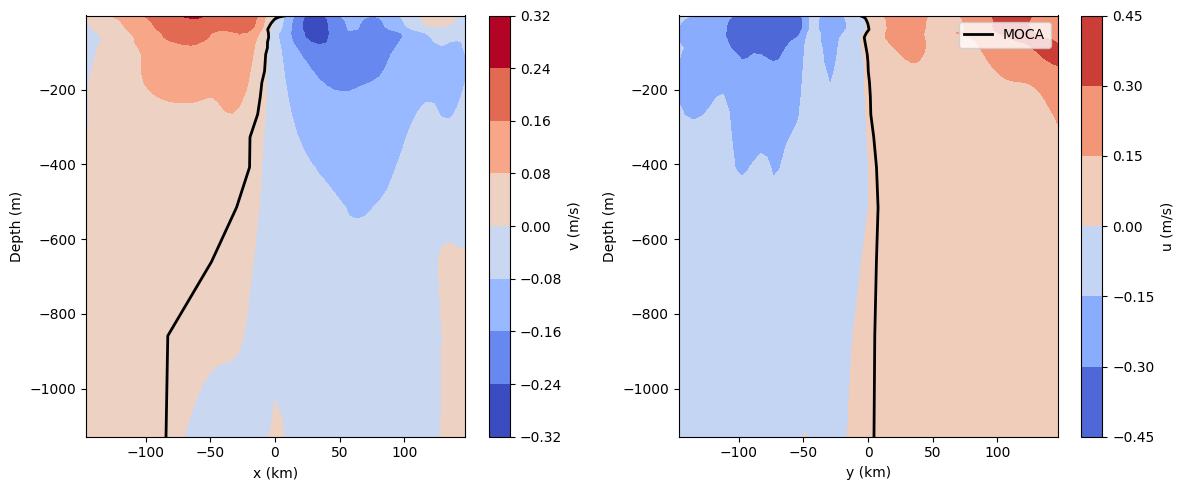

In [13]:
# PLOT

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

i_left, i_right, j_down, j_up = grid_finder(i_search, j_search, DISPLAY_WIDTH)
x, y = eddy_centric_grid_distances(i_search, j_search, i_left, i_right, j_down, j_up)

xcs, ycs, zcs, n_xcs, n_ycs = [], [],[], [], []
for depth_dic in depth_dics1.values():
    xcs.append(depth_dic['xc']/1000)
    ycs.append(depth_dic['yc']/1000)
    n_xcs.append(depth_dic['n_xc']/1000)
    n_ycs.append(depth_dic['n_yc']/1000)
    zcs.append(depth_dic['Depth'])
    
xcs, ycs = rotate_20_clockwise(xcs, ycs)

# Second subplot
v_cross = V[i_left:i_right, j_search, :DEPTH_LVL_LIMIT]
v_data_range = np.nanmax(np.abs(v_cross))
X, Z = np.meshgrid(x, z_r[150, 150, :DEPTH_LVL_LIMIT])
c1 = axs[0].contourf(X, Z, v_cross.T, cmap='coolwarm', vmin=-v_data_range, vmax=v_data_range)
axs[0].set_xlabel('x (km)')
axs[0].set_ylabel('Depth (m)')
axs[0].plot(xcs, zcs, '-', linewidth=2, color= 'k')
# axs[0].scatter(xcs, zcs)
fig.colorbar(c1, ax=axs[0], label='v (m/s)')

# Third subplot
u_cross = U[i_search, j_down:j_up, :DEPTH_LVL_LIMIT]
u_data_range = np.nanmax(np.abs(u_cross))
Y, Z = np.meshgrid(y, z_r[150, 150, :DEPTH_LVL_LIMIT])
c2 = axs[1].contourf(Y, Z, u_cross.T, cmap='coolwarm', vmin=-u_data_range, vmax=u_data_range)
axs[1].set_xlabel('y (km)')
axs[1].set_ylabel('Depth (m)')
axs[1].plot(ycs, zcs, '-', linewidth=2, color= 'k')
# axs[1].scatter(ycs, zcs)
fig.colorbar(c2, ax=axs[1], label='u (m/s)')
axs[1].legend(['MOCA'])

plt.tight_layout()
plt.show()

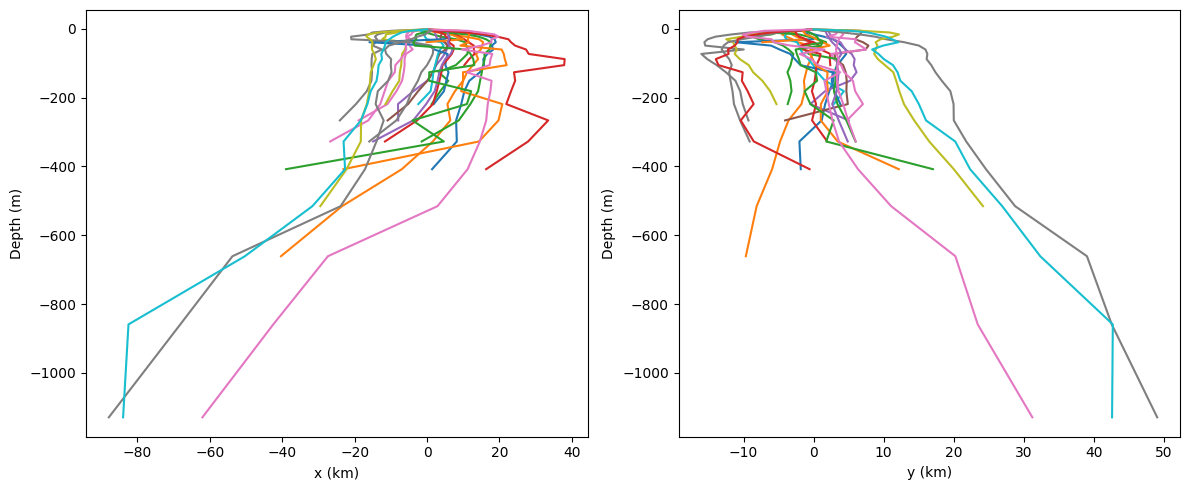

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for time_data in sample_data[eddy]['VG'].values():

    axs[0].plot(time_data['x'] - time_data.iloc[0]['x'], time_data['Depth'])

    axs[1].plot(time_data['y'] - time_data.iloc[0]['y'], time_data['Depth'])

axs[0].set_xlabel('x (km)')
axs[0].set_ylabel('Depth (m)')

axs[1].set_xlabel('y (km)')
axs[1].set_ylabel('Depth (m)')

plt.tight_layout()
plt.show()

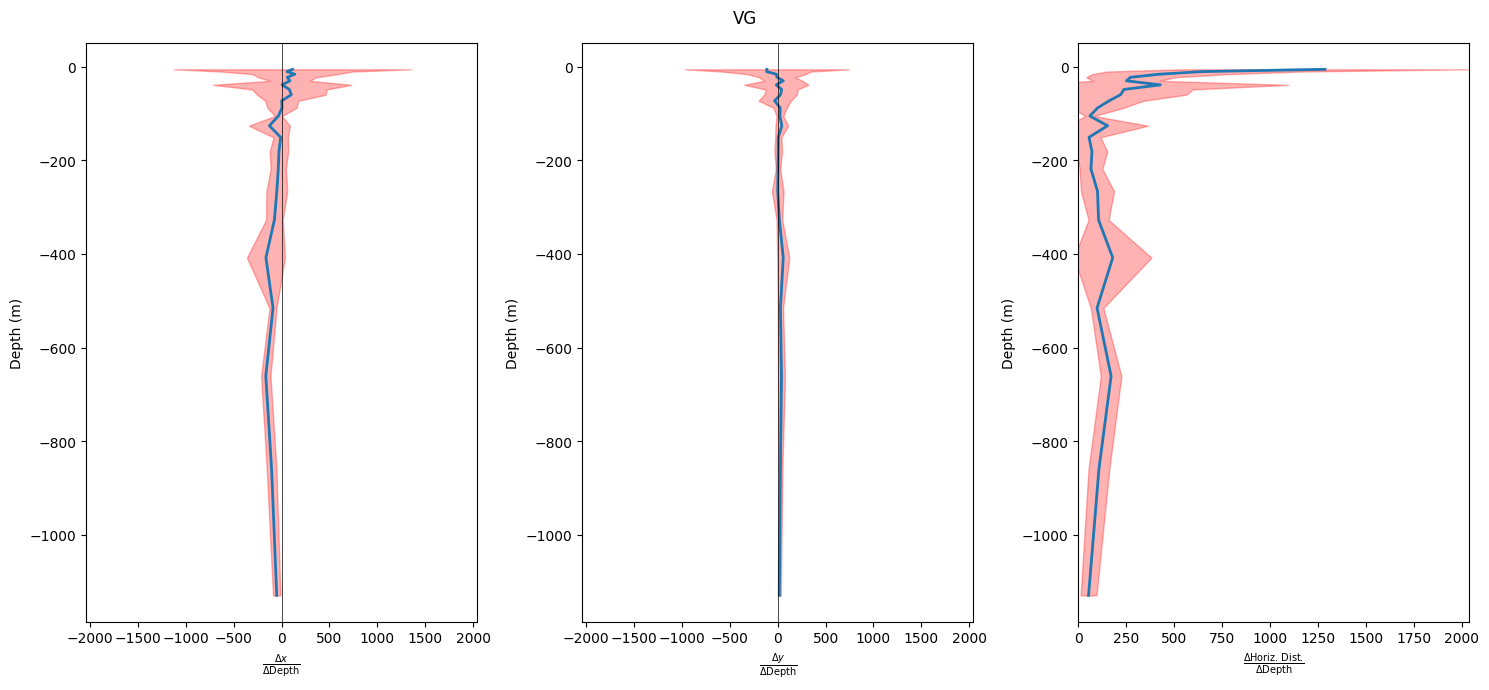

In [15]:
VG_x_df, VG_y_df, VG_x_diff_df, VG_y_diff_df, VG_TD_df, VG_D_df = process_eddy_data(sample_data, eddy, z_r[150, 150, :DEPTH_LVL_LIMIT]/1000, DEPTH_LVL_LIMIT, 'VG')

max_x_value = max(
    np.nanmax(abs(VG_x_diff_df['Mean'] + VG_x_diff_df['StdDev'])),
    np.nanmax(abs(VG_y_diff_df['Mean'] + VG_y_diff_df['StdDev'])),
    np.nanmax(abs(VG_D_df['Mean'] + VG_D_df['StdDev']))
)

fig, axs = plt.subplots(1, 3, figsize=(15, 7))

# Plot for Delta x / Depth
axs[0].plot(VG_x_diff_df['Mean'], VG_x_diff_df['Depth'], linewidth=2)
axs[0].fill_betweenx(VG_x_diff_df['Depth'], VG_x_diff_df['Mean'] - VG_x_diff_df['StdDev'], VG_x_diff_df['Mean'] + VG_x_diff_df['StdDev'], color='r', alpha=0.3)
axs[0].set_xlabel(r'$\frac{\Delta x}{ \Delta \text{Depth}}$')
axs[0].set_ylabel('Depth (m)')
axs[0].axvline(x=0, color='k', linewidth=0.5)
axs[0].set_xlim([-max_x_value, max_x_value])

# Plot for Delta y / Depth
axs[1].plot(VG_y_diff_df['Mean'], VG_y_diff_df['Depth'], linewidth=2)
axs[1].fill_betweenx(VG_y_diff_df['Depth'], VG_y_diff_df['Mean'] - VG_y_diff_df['StdDev'], VG_y_diff_df['Mean'] + VG_y_diff_df['StdDev'], color='r', alpha=0.3)
axs[1].set_xlabel(r'$\frac{\Delta y}{ \Delta \text{Depth}}$')
axs[1].set_ylabel('Depth (m)')
axs[1].axvline(x=0, color='k', linewidth=0.5)
axs[1].set_xlim([-max_x_value, max_x_value])

# Plot for Delta Horizontal Distance / Depth
axs[2].plot(VG_D_df['Mean'], VG_D_df['Depth'], linewidth=2)
axs[2].fill_betweenx(VG_D_df['Depth'], VG_D_df['Mean'] - VG_D_df['StdDev'], VG_D_df['Mean'] + VG_D_df['StdDev'], color='r', alpha=0.3)
axs[2].set_xlabel(r'$\frac{\Delta \text{Horiz. Dist.}}{ \Delta \text{Depth}}$')
axs[2].set_ylabel('Depth (m)')
axs[2].axvline(x=0, color='k', linewidth=0.5)
axs[2].set_xlim([0, max_x_value])

# Plot title and layout
plt.suptitle('VG')
plt.tight_layout()
plt.show()

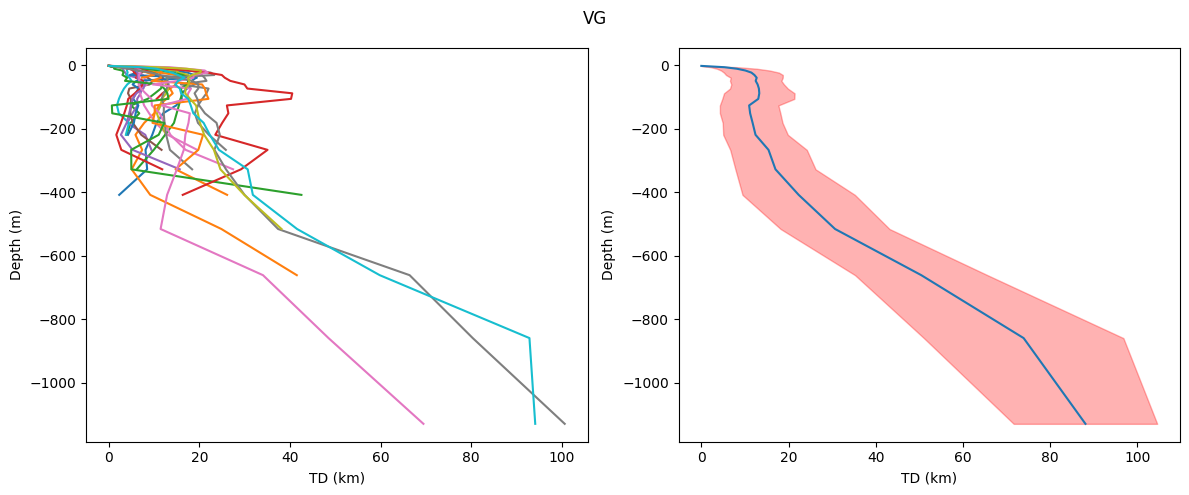

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for key in VG_TD_df.keys():
    if key not in ['Depth', 'Mean', 'StdDev']:
        axs[0].plot(VG_TD_df[key], z_r[150, 150, :DEPTH_LVL_LIMIT])
axs[0].set_xlabel('TD (km)')
axs[0].set_ylabel('Depth (m)')

axs[1].plot(VG_TD_df['Mean'], VG_TD_df['Depth'])
axs[1].fill_betweenx(VG_TD_df['Depth'], VG_TD_df['Mean'] - VG_TD_df['StdDev'], VG_TD_df['Mean'] + VG_TD_df['StdDev'], color='r', alpha=0.3)
axs[1].set_xlabel('TD (km)')
axs[1].set_ylabel('Depth (m)')

plt.suptitle('VG')
plt.tight_layout()
plt.show()


In [17]:
with open('/srv/scratch/z5297792/Sample/sample_data_CE8.pkl', 'wb') as file:
    pickle.dump(sample_data, file)

## LNAM

In [18]:
def calc_lnam(x, y, uu, vv):
    f = -1  # SH
    # Initialize arrays for spatial differences
    dx, dy = np.zeros_like(x), np.zeros_like(x)
    dux, duy, dvx, dvy = np.zeros_like(x), np.zeros_like(x), np.zeros_like(x), np.zeros_like(x)
    
    # Finite spatial element directly in meters
    dx[1:-1, 1:-1] = x[1:-1, 2:] - x[1:-1, :-2]
    dy[1:-1, 1:-1] = y[2:, 1:-1] - y[:-2, 1:-1]
    
    # Speed element in m/s
    dux[1:-1, 1:-1] = uu[1:-1, 2:] - uu[1:-1, :-2]
    duy[1:-1, 1:-1] = uu[2:, 1:-1] - uu[:-2, 1:-1]
    dvx[1:-1, 1:-1] = vv[1:-1, 2:] - vv[1:-1, :-2]
    dvy[1:-1, 1:-1] = vv[2:, 1:-1] - vv[:-2, 1:-1]

    epsilon = 1e-10  # A small number to prevent division by zero
    sn = np.divide((dux / (dx + epsilon)) - (dvy / (dy + epsilon)), 1, where=(dx > epsilon) & (dy > epsilon))
    ss = np.divide((dvx / (dx + epsilon)) + (duy / (dy + epsilon)), 1, where=(dx > epsilon) & (dy > epsilon))
    om = np.divide((dvx / (dx + epsilon)) - (duy / (dy + epsilon)), 1, where=(dx > epsilon) & (dy > epsilon))
    div = np.divide((dux / (dx + epsilon)) + (dvy / (dy + epsilon)), 1, where=(dx > epsilon) & (dy > epsilon))
    
    vorticity = om * np.sign(f)
    okubo = sn**2 + ss**2 - om**2  # in s^-2
    
    # Initialization
    LNAM, LOW = np.zeros_like(uu), np.full_like(uu, np.nan)
    b = np.ones_like(x, dtype=int) # 2b is the side length of the local box
    borders = np.max(b) + 1
    
    # Loop through domain to calculate LNAM and LOW
    for i in range(borders, len(vv[:, 0]) - borders + 1):
        for j in range(borders, len(vv[0, :]) - borders + 1):
            if not np.isnan(vv[i, j]):
                OW = okubo[i - b[i, j]:i + b[i, j] + 1, j - b[i, j]:j + b[i, j] + 1]
                LOW[i, j] = np.nanmean(OW)
                
                xlocal = x[i - b[i, j]:i + b[i, j] + 1, j - b[i, j]:j + b[i, j] + 1]
                ylocal = y[i - b[i, j]:i + b[i, j] + 1, j - b[i, j]:j + b[i, j] + 1]
                ulocal = uu[i - b[i, j]:i + b[i, j] + 1, j - b[i, j]:j + b[i, j] + 1]
                vlocal = vv[i - b[i, j]:i + b[i, j] + 1, j - b[i, j] + 1]
                
                coordcentre = (xlocal.shape[0] - 1) // 2
                d_xcentre = (xlocal - xlocal[coordcentre, coordcentre])
                d_ycentre = (ylocal - ylocal[coordcentre, coordcentre])
                
                cross = (d_xcentre * vlocal) - (d_ycentre * ulocal)
                dot = (ulocal * d_xcentre) + (vlocal * d_ycentre)
                produit = np.sqrt(ulocal**2 + vlocal**2) * np.sqrt(d_xcentre**2 + d_ycentre**2)
                sumdp = np.sum(dot) + np.sum(produit)
                
                LNAM[i, j] = np.sum(cross) / sumdp * np.sign(f) if sumdp != 0 else 0
    
    LNAM[np.isnan(LNAM)] = 0
    return LNAM, LOW


In [19]:
sample_data[eddy]['LNAM'] = {}

In [20]:
from scipy.ndimage import maximum_filter, minimum_filter

for t in range(sample_data[eddy]['U'].shape[-1]):

    SEARCH_WIDTH = 200000
    DEPTH_LVL_LIMIT = 23
    R_BETWEEN_ADJACENT_CENTERS = 30000

    U = sample_data[eddy]['U'][:,:,:,t]
    V = sample_data[eddy]['V'][:,:,:,t]
    
    t0 = eddies[eddy].shape[0] // 2 - 15
    t_eddy_relative = t + t0
    edata = eddies[eddy].iloc[t_eddy_relative]
    i_search, j_search = eddies_nearest_rho(edata.Lon, edata.Lat)

    depth_dics2 = {}
    clon, clat = edata.Lon, edata.Lat

    i_search_lvl, j_search_lvl = eddies_nearest_rho(clon, clat)
    i_left, i_right, j_down, j_up = grid_finder(i_search_lvl, j_search_lvl, SEARCH_WIDTH)

    dx = SEARCH_WIDTH // 100

    for depth_lvl in range(DEPTH_LVL_LIMIT):

        x, y = eddy_centric_grid_distances(i_search_lvl, j_search_lvl, i_left, i_right, j_down, j_up)

        _, _, u = interpolate_to_dx_spacing(x*1000, y*1000, U[i_left:i_right, j_down:j_up, depth_lvl].squeeze(), dx)
        x, y, v = interpolate_to_dx_spacing(x*1000, y*1000, V[i_left:i_right, j_down:j_up, depth_lvl].squeeze(), dx)
    
        X, Y = np.meshgrid(x, y)
    
        lnam, low = calc_lnam(X, Y, u, v)
        if np.any(np.isfinite(lnam)):
            window_size = 9
            if edata.Vort < 0:
                local_maxima = maximum_filter(lnam, size=window_size, mode='reflect')
                local_maxima_positions = (lnam == local_maxima)
                ic, jc = np.argwhere(local_maxima_positions).T

            elif edata.Vort > 0:
                local_minima = minimum_filter(lnam, size=window_size, mode='reflect')
                local_minima_positions = (lnam == local_minima)
                ic, jc = np.argwhere(local_minima_positions).T
            
            # ic, jc = int(ic), int(jc)

            if depth_lvl == 0:
                ic_pre, jc_pre = u.shape[0] // 2, u.shape[1] // 2
            else:
                ic_pre, jc_pre = depth_dics2['Depth'+str(depth_lvl-1)]['ic'], depth_dics2['Depth'+str(depth_lvl-1)]['jc']
        
            R = np.sqrt((ic - ic_pre)**2 + (jc - jc_pre)**2) * dx
            ic = ic[R < R_BETWEEN_ADJACENT_CENTERS]
            jc = jc[R < R_BETWEEN_ADJACENT_CENTERS]

            if len(ic) > 1:
                if edata.Vort < 0:
                    idx = np.argmax(vel_mag)
                elif edata.Vort > 0:
                    idx = np.argin(vel_mag)
                ic, jc = [ic[idx]], [jc[idx]]

            if len(ic) > 0:
                ic, jc = ic[0], jc[0]
                xc = X.T[ic, jc]
                yc = Y.T[ic, jc]
            else:
                ic, jc, xc, yc = np.nan, np.nan, np.nan, np.nan
        else:
            ic, jc, xc, yc = np.nan, np.nan, np.nan, np.nan

        depth_dics2['Depth'+str(depth_lvl)] = {'lnam': lnam, 'ic': ic, 'jc': jc,
                                                   'xc': xc, 'yc': yc,
                                                   'X': X, 'Y': Y, 'u': u, 'v': v,
                                                   'Depth': float(z_r[150, 150, depth_lvl])}
        
    xcs, ycs, zcs = [], [],[]
    for depth_dic in depth_dics2.values():
        xcs.append(depth_dic['xc']/1000)
        ycs.append(depth_dic['yc']/1000)
        zcs.append(depth_dic['Depth'])
    
    sample_data[eddy]['LNAM']['T'+str(t)] = pd.DataFrame({
        'x': xcs,
        'y': ycs,
        'Depth': zcs
    })
    print(t)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


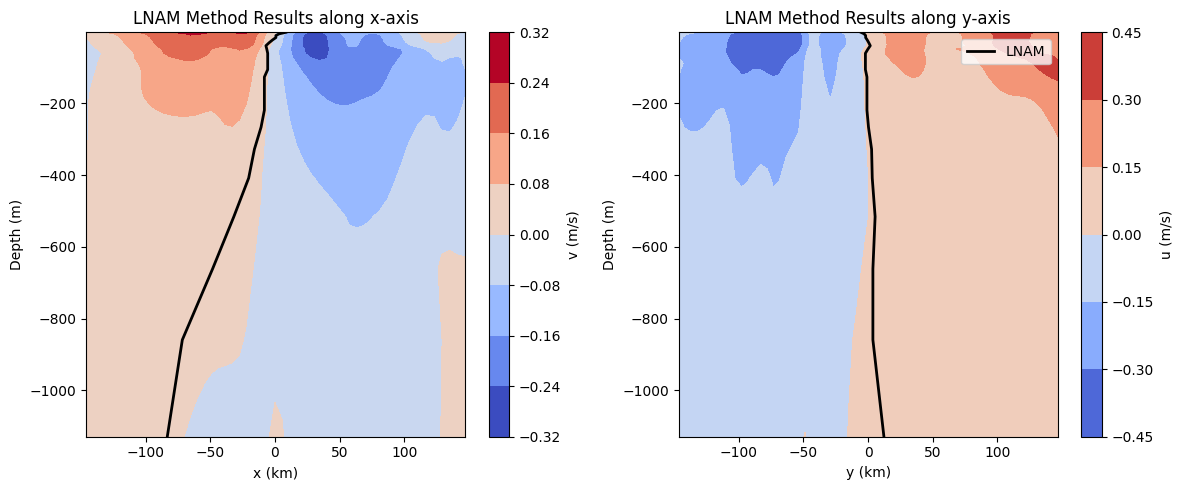

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

i_left, i_right, j_down, j_up = grid_finder(i_search, j_search, DISPLAY_WIDTH)
x, y = eddy_centric_grid_distances(i_search, j_search, i_left, i_right, j_down, j_up)

xcs, ycs, zcs = [], [] ,[]
for depth_dic in depth_dics2.values():
    xcs.append(depth_dic['xc']/1000)
    ycs.append(depth_dic['yc']/1000)
    zcs.append(depth_dic['Depth'])

xcs, ycs = rotate_20_clockwise(xcs, ycs)

# Second subplot
v_cross = V[i_left:i_right, j_search, :DEPTH_LVL_LIMIT]
v_data_range = np.nanmax(np.abs(v_cross))
X, Z = np.meshgrid(x, z_r[150, 150, :DEPTH_LVL_LIMIT])
c1 = axs[0].contourf(X, Z, v_cross.T, cmap='coolwarm', vmin=-v_data_range, vmax=v_data_range)
# c1_contour = axs[0].contour(X, Z, v_cross.T, levels=[0], colors='black', linestyles='--')
axs[0].set_xlabel('x (km)')
axs[0].set_ylabel('Depth (m)')
axs[0].plot(xcs, zcs, '-', linewidth=2, color= 'k')
# axs[0].scatter(xcs, zcs)
fig.colorbar(c1, ax=axs[0], label='v (m/s)')
axs[0].set_title('LNAM Method Results along x-axis')

# Third subplot
u_cross = U[i_search, j_down:j_up, :DEPTH_LVL_LIMIT]
u_data_range = np.nanmax(np.abs(u_cross))
Y, Z = np.meshgrid(y, z_r[150, 150, :DEPTH_LVL_LIMIT])
c2 = axs[1].contourf(Y, Z, u_cross.T, cmap='coolwarm', vmin=-u_data_range, vmax=u_data_range)
# c2_contour = axs[1].contour(Y, Z, u_cross.T, levels=[0], colors='black', linestyles='--')
axs[1].set_xlabel('y (km)')
axs[1].set_ylabel('Depth (m)')
axs[1].plot(ycs, zcs, '-', linewidth=2, color= 'k')
# axs[1].scatter(ycs, zcs)
fig.colorbar(c2, ax=axs[1], label='u (m/s)')
axs[1].legend(['LNAM'])
axs[1].set_title('LNAM Method Results along y-axis')

plt.tight_layout()
plt.show()

Depth -2


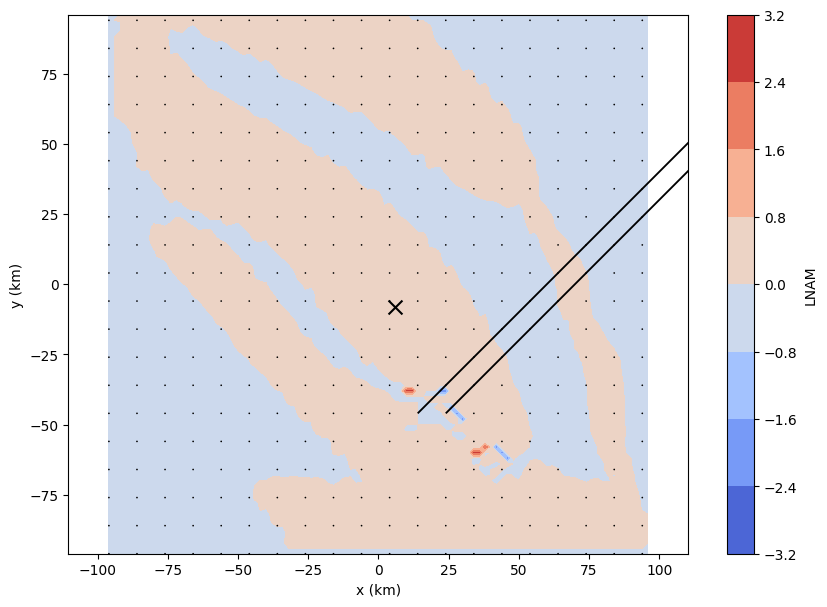

In [22]:
DEPTH_LVL = 0

depth_dic = depth_dics2['Depth'+str(DEPTH_LVL)]

plt.figure(figsize=(10,7))

c = plt.contourf(depth_dic['X']/1000, depth_dic['Y']/1000, depth_dic['lnam'].T, cmap='coolwarm')
plt.scatter(depth_dic['xc']/1000, depth_dic['yc']/1000, color='k', marker='x', s=100)
plt.colorbar(c, label='LNAM')

spacing = 5
plt.quiver(depth_dic['X'][::spacing,::spacing]/1000, depth_dic['Y'][::spacing,::spacing]/1000, depth_dic['u'][::spacing,::spacing].T, depth_dic['v'][::spacing,::spacing].T)

plt.axis('equal')
plt.xlabel('x (km)')
plt.ylabel('y (km)')

print('Depth ' + str(round(z_r[150, 150, DEPTH_LVL])))

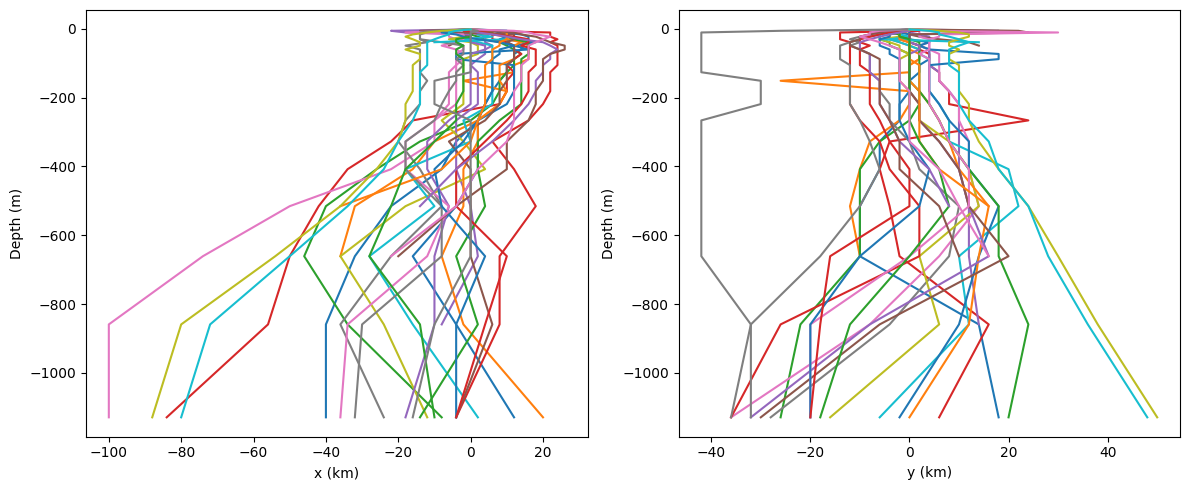

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for time_data in sample_data[eddy]['LNAM'].values():

    axs[0].plot(time_data['x'] - time_data.iloc[0]['x'], time_data['Depth'])

    axs[1].plot(time_data['y'] - time_data.iloc[0]['y'], time_data['Depth'])

axs[0].set_xlabel('x (km)')
axs[0].set_ylabel('Depth (m)')

axs[1].set_xlabel('y (km)')
axs[1].set_ylabel('Depth (m)')

plt.tight_layout()
plt.show()


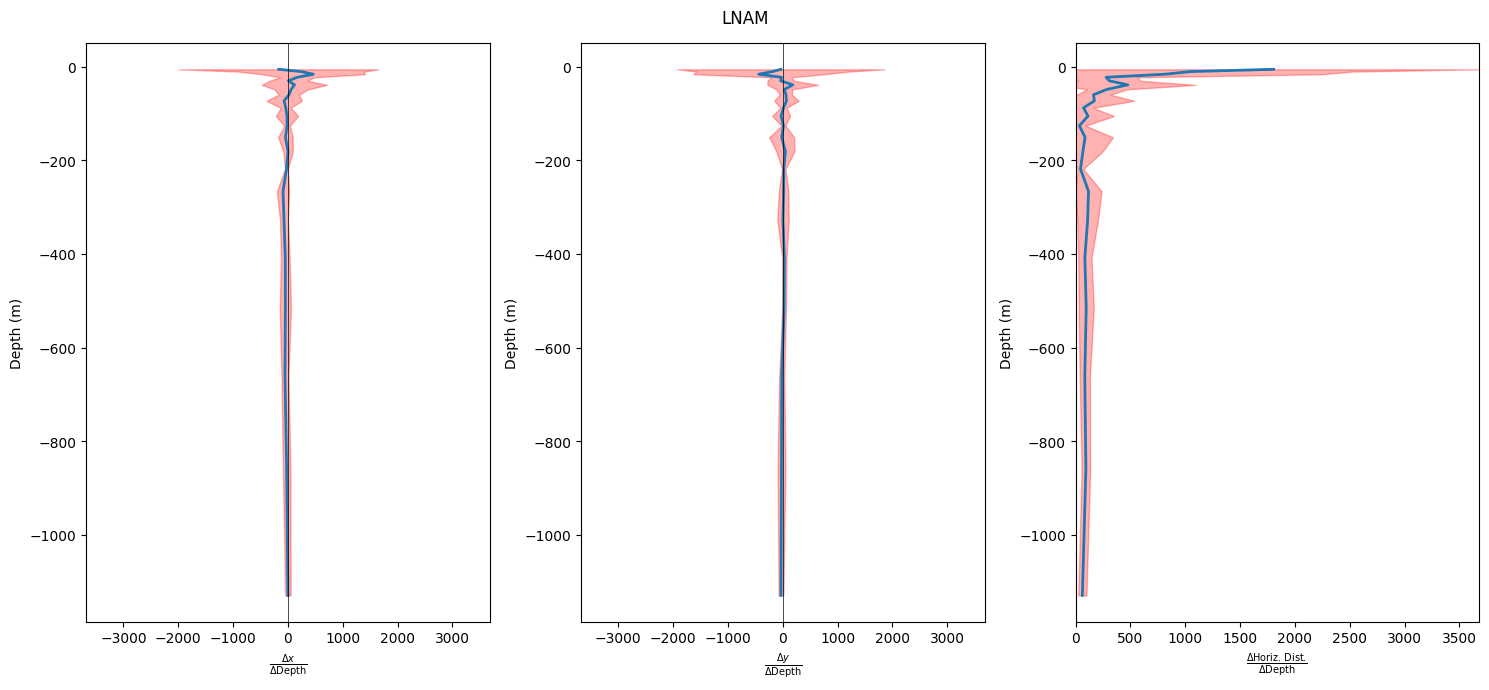

In [24]:
LNAM_x_df, LNAM_y_df, LNAM_x_diff_df, LNAM_y_diff_df, LNAM_TD_df, LNAM_D_df = process_eddy_data(sample_data, eddy, z_r[150, 150, :DEPTH_LVL_LIMIT]/1000, DEPTH_LVL_LIMIT, 'LNAM')

max_x_value = max(
    np.nanmax(abs(LNAM_x_diff_df['Mean'] + LNAM_x_diff_df['StdDev'])),
    np.nanmax(abs(LNAM_y_diff_df['Mean'] + LNAM_y_diff_df['StdDev'])),
    np.nanmax(abs(LNAM_D_df['Mean'] + LNAM_D_df['StdDev']))
)

fig, axs = plt.subplots(1, 3, figsize=(15, 7))

# Plot for Delta x / Depth
axs[0].plot(LNAM_x_diff_df['Mean'], LNAM_x_diff_df['Depth'], linewidth=2)
axs[0].fill_betweenx(LNAM_x_diff_df['Depth'], LNAM_x_diff_df['Mean'] - LNAM_x_diff_df['StdDev'], LNAM_x_diff_df['Mean'] + LNAM_x_diff_df['StdDev'], color='r', alpha=0.3)
axs[0].set_xlabel(r'$\frac{\Delta x}{ \Delta \text{Depth}}$')
axs[0].set_ylabel('Depth (m)')
axs[0].axvline(x=0, color='k', linewidth=0.5)
axs[0].set_xlim([-max_x_value, max_x_value])

# Plot for Delta y / Depth
axs[1].plot(LNAM_y_diff_df['Mean'], LNAM_y_diff_df['Depth'], linewidth=2)
axs[1].fill_betweenx(LNAM_y_diff_df['Depth'], LNAM_y_diff_df['Mean'] - LNAM_y_diff_df['StdDev'], LNAM_y_diff_df['Mean'] + LNAM_y_diff_df['StdDev'], color='r', alpha=0.3)
axs[1].set_xlabel(r'$\frac{\Delta y}{ \Delta \text{Depth}}$')
axs[1].set_ylabel('Depth (m)')
axs[1].axvline(x=0, color='k', linewidth=0.5)
axs[1].set_xlim([-max_x_value, max_x_value])

# Plot for Delta Horizontal Distance / Depth
axs[2].plot(LNAM_D_df['Mean'], LNAM_D_df['Depth'], linewidth=2)
axs[2].fill_betweenx(LNAM_D_df['Depth'], LNAM_D_df['Mean'] - LNAM_D_df['StdDev'], LNAM_D_df['Mean'] + LNAM_D_df['StdDev'], color='r', alpha=0.3)
axs[2].set_xlabel(r'$\frac{\Delta \text{Horiz. Dist.}}{ \Delta \text{Depth}}$')
axs[2].set_ylabel('Depth (m)')
axs[2].axvline(x=0, color='k', linewidth=0.5)
axs[2].set_xlim([0, max_x_value])

# Plot title and layout
plt.suptitle('LNAM')
plt.tight_layout()
plt.show()

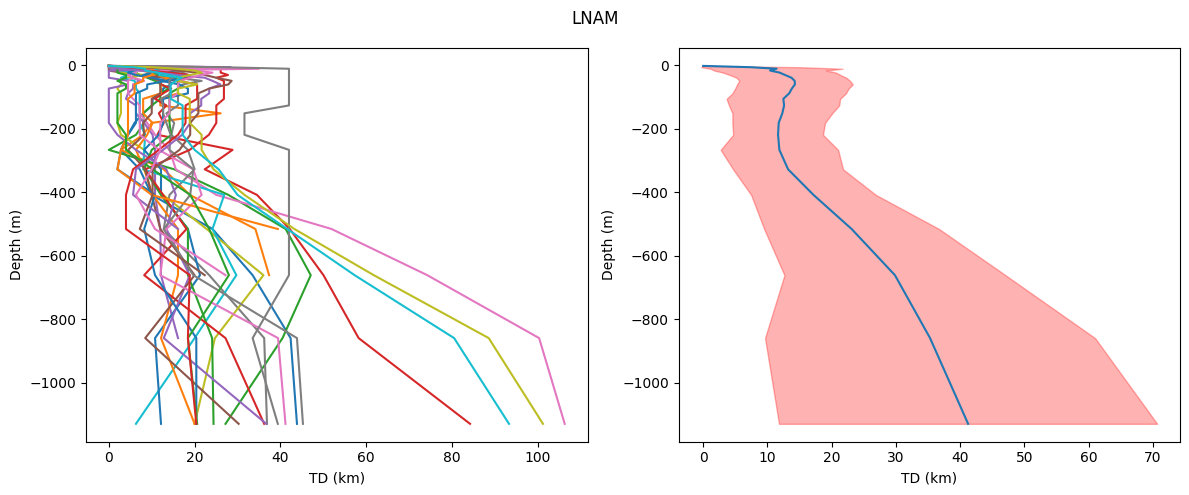

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for key in LNAM_TD_df.keys():
    if key not in ['Depth', 'Mean', 'StdDev']:
        axs[0].plot(LNAM_TD_df[key], z_r[150, 150, :DEPTH_LVL_LIMIT])
axs[0].set_xlabel('TD (km)')
axs[0].set_ylabel('Depth (m)')

axs[1].plot(LNAM_TD_df['Mean'], LNAM_TD_df['Depth'])
axs[1].fill_betweenx(LNAM_TD_df['Depth'], LNAM_TD_df['Mean'] - LNAM_TD_df['StdDev'], LNAM_TD_df['Mean'] + LNAM_TD_df['StdDev'], color='r', alpha=0.3)
axs[1].set_xlabel('TD (km)')
axs[1].set_ylabel('Depth (m)')

plt.suptitle('LNAM')
plt.tight_layout()
plt.show()

# COW

In [26]:
def calculate_okubo_weis(uu, vv, dx, dy):

    uu = np.where(uu > 100, 0, uu)
    vv = np.where(vv > 100, 0, vv)
    
    WIDTH, LENGTH, SIGMAS = uu.shape
    u_x = (uu[2:,:,:] - uu[:-2,:,:]) / (2*dx)
    u_y = (uu[:,2:,:] - uu[:,:-2,:]) / (2*dy)
    v_x = (vv[2:,:,:] - vv[:-2,:,:]) / (2*dx)
    v_y = (vv[:,2:,:] - vv[:,:-2,:]) / (2*dy)
    u_x = np.concatenate((np.zeros((1, LENGTH, SIGMAS)), u_x, np.zeros((1, LENGTH, SIGMAS))), axis=0)
    v_x = np.concatenate((np.zeros((1, LENGTH, SIGMAS)), v_x, np.zeros((1, LENGTH, SIGMAS))), axis=0)
    u_y = np.concatenate((np.zeros((WIDTH, 1, SIGMAS)), u_y, np.zeros((WIDTH, 1, SIGMAS))), axis=1)
    v_y = np.concatenate((np.zeros((WIDTH, 1, SIGMAS)), v_y, np.zeros((WIDTH, 1, SIGMAS))), axis=1)
    s_n = u_x - v_y
    s_s = v_x + u_y
    vort = v_x - u_y
    ow = s_n**2 + s_s**2 - vort**2
    return ow
    
def normalize_matrix(LOW):
    ocean_mask = np.where(np.isnan(LOW), np.zeros_like(LOW), 1)
    OW_mean = np.nansum(LOW) / np.sum(ocean_mask)
    OW_std = np.sqrt(np.nansum(ocean_mask * (LOW - OW_mean) ** 2) / np.sum(ocean_mask))
    return LOW / OW_std

In [27]:
sample_data[eddy]['COW'] = {}

In [28]:
for t in range(sample_data[eddy]['U'].shape[-1]):

    SEARCH_WIDTH = 300000
    DEPTH_LVL_LIMIT = 23

    t0 = eddies[eddy].shape[0] // 2 - 15
    t_eddy_relative = t + t0
    edata = eddies[eddy].iloc[t_eddy_relative]
    i_search, j_search = eddies_nearest_rho(edata.Lon, edata.Lat)
    
    i_left, i_right, j_down, j_up = grid_finder(i_search, j_search, SEARCH_WIDTH)
    x_roms, y_roms = eddy_centric_grid_distances(i_search, j_search, i_left, i_right, j_down, j_up)
    x_roms *= 1000
    y_roms *= 1000

    U = sample_data[eddy]['U'][:,:,:,t]
    V = sample_data[eddy]['V'][:,:,:,t]
    
    dx = SEARCH_WIDTH // 100
    depth_dics3 = {}
    for depth_lvl in range(DEPTH_LVL_LIMIT):
        if depth_lvl == 0:
            _, _, u_int0 = interpolate_to_dx_spacing(x_roms, y_roms, U[i_left:i_right, j_down:j_up, depth_lvl], dx)
            x, y, v_int0 = interpolate_to_dx_spacing(x_roms, y_roms, V[i_left:i_right, j_down:j_up, depth_lvl], dx)
    
            u_int = np.zeros((*u_int0.shape, DEPTH_LVL_LIMIT))
            v_int = np.zeros((*v_int0.shape, DEPTH_LVL_LIMIT))
            u_int[:, :, depth_lvl] = u_int0
            v_int[:, :, depth_lvl] = v_int0
        else:
            _, _, u_int1 = interpolate_to_dx_spacing(x_roms, y_roms, U[i_left:i_right, j_down:j_up, depth_lvl], dx)
            _, _, v_int1 = interpolate_to_dx_spacing(x_roms, y_roms, V[i_left:i_right, j_down:j_up, depth_lvl], dx)
    
            u_int[:, :, depth_lvl] = u_int1
            v_int[:, :, depth_lvl] = v_int1
    
    ow = normalize_matrix(calculate_okubo_weis(u_int, v_int, dx, dx))
    cs = np.sqrt(u_int**2 + v_int**2)
    
    X, Y = np.meshgrid(x, y)
    
    CS_THRESH = 0.05
    OW_THRESH = -.2
    RATIO_THRESH = 2/3
    SEARCH_RADIUS_MAX = 50000
    
    xc, yc = 0, 0
    for depth_lvl in range(DEPTH_LVL_LIMIT):
        Search_Radius = 5000
        df = pd.DataFrame({'x': [np.nan, np.nan], 'y': [np.nan, np.nan]})
        xc_keep, yc_keep = np.nan, np.nan
        while Search_Radius <= SEARCH_RADIUS_MAX:
            R = np.sqrt((X - xc)**2 + (Y - yc)**2)
            mask = R < Search_Radius
            cur_speed_masked = np.where(mask, cs[:, :, depth_lvl], np.nan) 
            ow_masked = np.where(mask, ow[:, :, depth_lvl], np.nan) 
            pot_i, pot_j = np.where((cur_speed_masked < CS_THRESH) & (ow_masked < OW_THRESH))
            ratio = len(pot_i) / np.sum(mask) if len(pot_i) != 0 else 0
            if ratio <= RATIO_THRESH and ratio != 0:
                A = np.array([x[pot_i], y[pot_j]])
                xc, yc = np.mean(A, axis=1)
                xc_keep, yc_keep = xc, yc
                df = pd.DataFrame({
                    'x': x[pot_i],
                    'y': y[pot_j],
                    'OW': ow_masked[pot_i, pot_j],
                    'CurSpeed': cur_speed_masked[pot_i, pot_j]
                })
                break
            Search_Radius += 5000
        depth_dics3['Depth'+str(depth_lvl)] = {'xc': xc_keep, 'yc': yc_keep, 'SR': Search_Radius,
                                               'OW': ow[: :, depth_lvl], 'CS': cs[:, :,depth_lvl],
                                               'x': x, 'y': y, 'dx': dx, 'df': df,
                                              'Depth': z_r[150, 150, depth_lvl]}

    xcs, ycs, zcs = [], [], []
    for depth_dic in depth_dics3.values():
        xcs.append(depth_dic['xc']/1000)
        ycs.append(depth_dic['yc']/1000)
        zcs.append(depth_dic['Depth'])
    
    sample_data[eddy]['COW']['T'+str(t)] = pd.DataFrame({
        'x': xcs,
        'y': ycs,
        'Depth': zcs
    })
    print(t)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


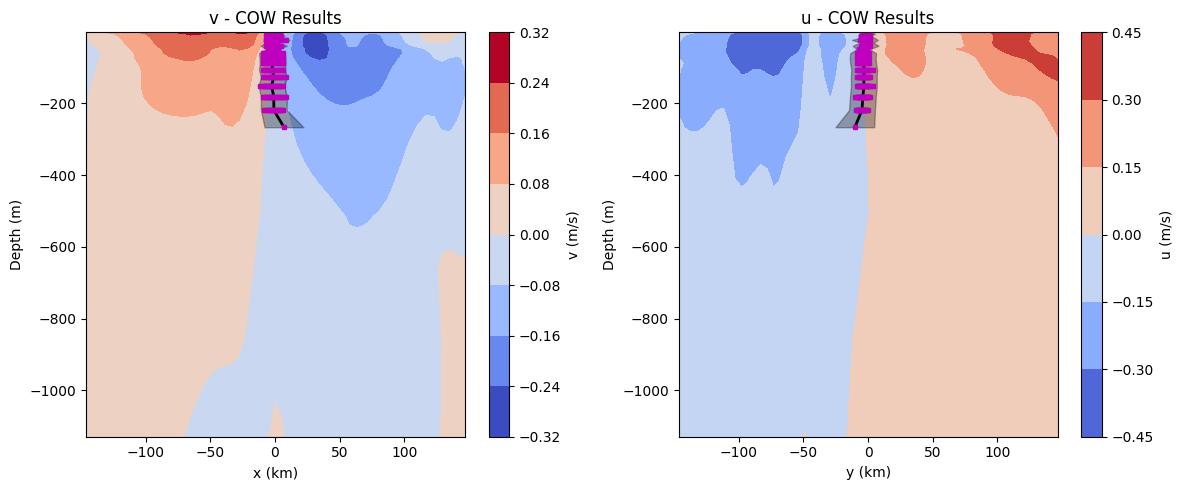

In [29]:
i_left, i_right, j_down, j_up = grid_finder(i_search, j_search, SEARCH_WIDTH)
x, y = eddy_centric_grid_distances(i_search, j_search, i_left, i_right, j_down, j_up)
z = z_r[150, 150, :DEPTH_LVL_LIMIT]
xc_raw, yc_raw, zc, xp_raw, yp_raw, zp, radii = [], [], [], [], [], [], []
for depth_dic in depth_dics3.values():
    xc_raw.append(depth_dic['xc']/1000)
    yc_raw.append(depth_dic['yc']/1000)
    zc.append(depth_dic['Depth'])
    radii.append(depth_dic['SR']/1000)
    xp_raw.extend(depth_dic['df'].x/1000)
    yp_raw.extend(depth_dic['df'].y/1000)
    zp.extend([float(depth_dic['Depth'])]*len(depth_dic['df'].x))
zp = np.array(zp)
xc, yc = rotate_20_clockwise(xc_raw, yc_raw)
xp, yp = rotate_20_clockwise(xp_raw, yp_raw)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# First subplot
v_cross = V[i_left:i_right, j_search, :DEPTH_LVL_LIMIT]
v_data_range = np.nanmax(np.abs(v_cross))
X, Z = np.meshgrid(x, z)
c1 = axs[0].contourf(X, Z, v_cross.T, cmap='coolwarm', vmin=-v_data_range, vmax=v_data_range)
# c1_contour = axs[0].contour(X, Z, v_cross.T, levels=[0], colors='black', linestyles='--')
axs[0].set_xlabel('x (km)')
axs[0].set_ylabel('Depth (m)')
axs[0].set_title('v - COW Results')
c, = axs[0].plot(xc, zc, '-', linewidth=2, color='k')
m, = axs[0].plot(xp, zp, 's', markersize=3, color='m')
# axs[0].plot([xc-radii, xc+radii], [zc, zc], '-', linewidth=1, color='m')
sa = axs[0].fill_betweenx(zc, xc - radii, xc + radii, color='k', alpha=0.3)
# axs[0].legend([c, m, sa, c1_contour], ['Centroid Line', 'Pot. Centers', 'Search Region'], loc='lower left')
fig.colorbar(c1, ax=axs[0], label='v (m/s)')

# Second subplot
u_cross = U[i_search, j_down:j_up, :DEPTH_LVL_LIMIT]
u_data_range = np.nanmax(np.abs(u_cross))
Y, Z = np.meshgrid(y, z)
c2 = axs[1].contourf(Y, Z, u_cross.T, cmap='coolwarm', vmin=-u_data_range, vmax=u_data_range)
# c2_contour = axs[1].contour(Y, Z, u_cross.T, levels=[0], colors='black', linestyles='--')
axs[1].set_xlabel('y (km)')
axs[1].set_ylabel('Depth (m)')
axs[1].set_title('u - COW Results')
axs[1].plot(yc, zc, '-', linewidth=2, color='k')
axs[1].plot(yp, zp, 's', markersize=3, color='m')
# axs[1].plot([yc-radii, yc+radii], [zc, zc], '-', linewidth=1, color='m')
axs[1].fill_betweenx(zc, yc - radii, yc + radii, color='k', alpha=0.3)
fig.colorbar(c2, ax=axs[1], label='u (m/s)')

plt.tight_layout()
plt.show()

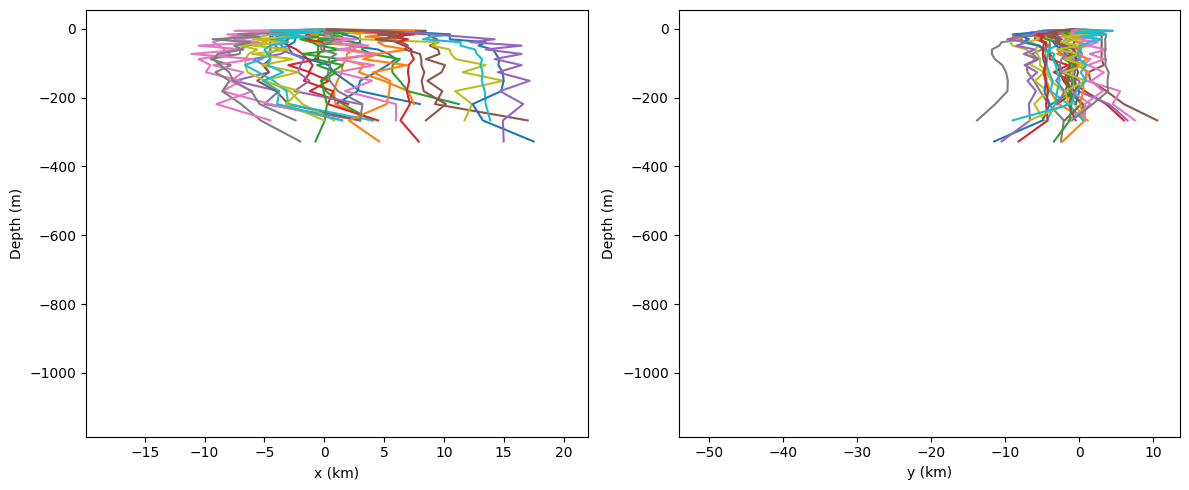

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for time_data in sample_data[eddy]['COW'].values():

    axs[0].plot(time_data['x'] - time_data.iloc[0]['x'], time_data['Depth'])

    axs[1].plot(time_data['y'] - time_data.iloc[0]['y'], time_data['Depth'])

axs[0].set_xlabel('x (km)')
axs[0].set_ylabel('Depth (m)')

axs[1].set_xlabel('y (km)')
axs[1].set_ylabel('Depth (m)')

plt.tight_layout()
plt.show()

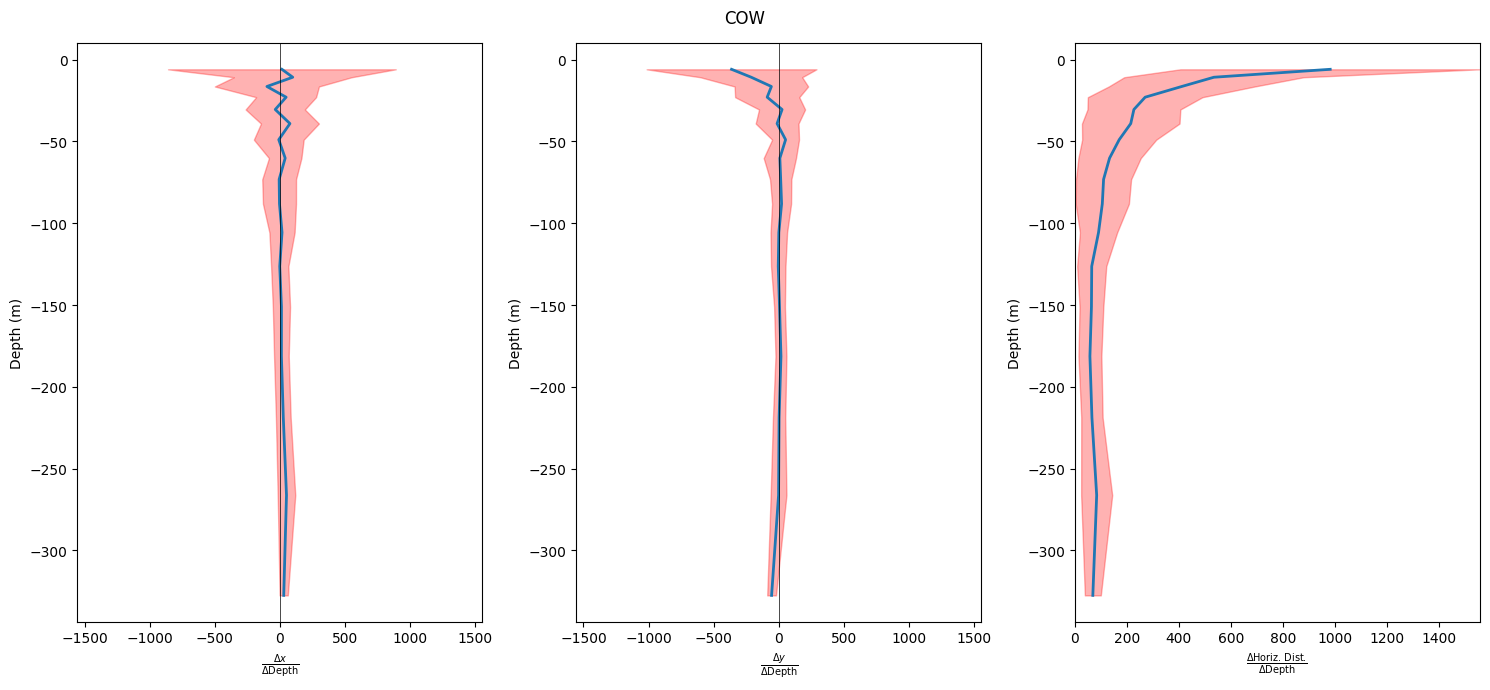

In [31]:
COW_x_df, COW_y_df, COW_x_diff_df, COW_y_diff_df, COW_TD_df, COW_D_df = process_eddy_data(sample_data, eddy, z_r[150, 150, :DEPTH_LVL_LIMIT]/1000, DEPTH_LVL_LIMIT, 'COW')

max_x_value = max(
    np.nanmax(abs(COW_x_diff_df['Mean'] + COW_x_diff_df['StdDev'])),
    np.nanmax(abs(COW_y_diff_df['Mean'] + COW_y_diff_df['StdDev'])),
    np.nanmax(abs(COW_D_df['Mean'] + COW_D_df['StdDev']))
)

fig, axs = plt.subplots(1, 3, figsize=(15, 7))

# Plot for Delta x / Depth
axs[0].plot(COW_x_diff_df['Mean'], COW_x_diff_df['Depth'], linewidth=2)
axs[0].fill_betweenx(COW_x_diff_df['Depth'], COW_x_diff_df['Mean'] - COW_x_diff_df['StdDev'], COW_x_diff_df['Mean'] + COW_x_diff_df['StdDev'], color='r', alpha=0.3)
axs[0].set_xlabel(r'$\frac{\Delta x}{ \Delta \text{Depth}}$')
axs[0].set_ylabel('Depth (m)')
axs[0].axvline(x=0, color='k', linewidth=0.5)
axs[0].set_xlim([-max_x_value, max_x_value])

# Plot for Delta y / Depth
axs[1].plot(COW_y_diff_df['Mean'], COW_y_diff_df['Depth'], linewidth=2)
axs[1].fill_betweenx(COW_y_diff_df['Depth'], COW_y_diff_df['Mean'] - COW_y_diff_df['StdDev'], COW_y_diff_df['Mean'] + COW_y_diff_df['StdDev'], color='r', alpha=0.3)
axs[1].set_xlabel(r'$\frac{\Delta y}{ \Delta \text{Depth}}$')
axs[1].set_ylabel('Depth (m)')
axs[1].axvline(x=0, color='k', linewidth=0.5)
axs[1].set_xlim([-max_x_value, max_x_value])

# Plot for Delta Horizontal Distance / Depth
axs[2].plot(COW_D_df['Mean'], COW_D_df['Depth'], linewidth=2)
axs[2].fill_betweenx(COW_D_df['Depth'], COW_D_df['Mean'] - COW_D_df['StdDev'], COW_D_df['Mean'] + COW_D_df['StdDev'], color='r', alpha=0.3)
axs[2].set_xlabel(r'$\frac{\Delta \text{Horiz. Dist.}}{ \Delta \text{Depth}}$')
axs[2].set_ylabel('Depth (m)')
axs[2].axvline(x=0, color='k', linewidth=0.5)
axs[2].set_xlim([0, max_x_value])

# Plot title and layout
plt.suptitle('COW')
plt.tight_layout()
plt.show()

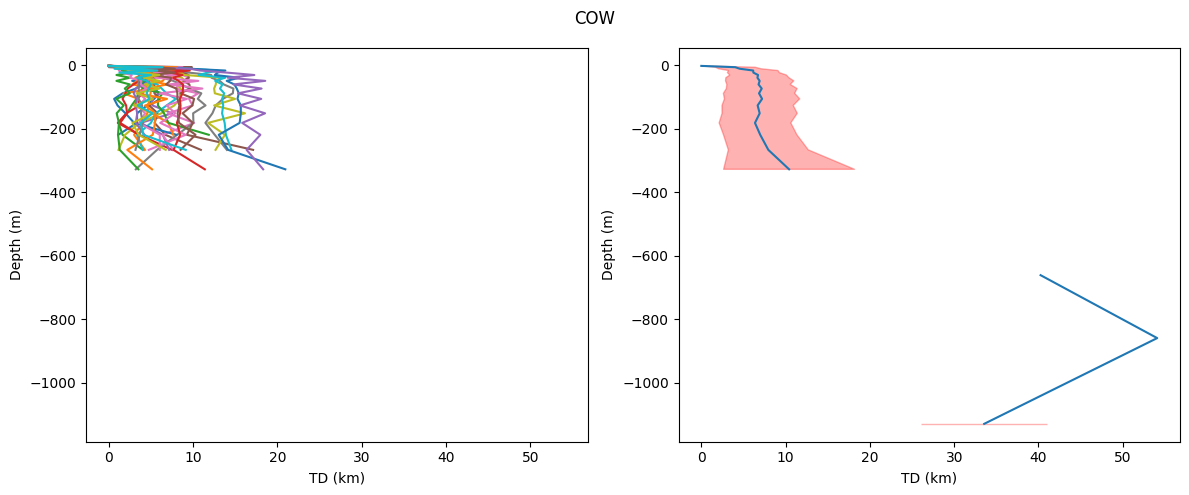

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for key in COW_TD_df.keys():
    if key not in ['Depth', 'Mean', 'StdDev']:
        axs[0].plot(COW_TD_df[key], z_r[150, 150, :DEPTH_LVL_LIMIT])
axs[0].set_xlabel('TD (km)')
axs[0].set_ylabel('Depth (m)')

axs[1].plot(COW_TD_df['Mean'], COW_TD_df['Depth'])
axs[1].fill_betweenx(COW_TD_df['Depth'], COW_TD_df['Mean'] - COW_TD_df['StdDev'], COW_TD_df['Mean'] + COW_TD_df['StdDev'], color='r', alpha=0.3)
axs[1].set_xlabel('TD (km)')
axs[1].set_ylabel('Depth (m)')

plt.suptitle('COW')
plt.tight_layout()
plt.show()

In [33]:
with open('/srv/scratch/z5297792/Sample/sample_data_CE8.pkl', 'wb') as file:
    pickle.dump(sample_data, file)

In [ ]:
break

# SSIM

In [ ]:
from skimage.metrics import structural_similarity as ssim

def correlation_center_finder(grid1, grid2):
    def cycle_matrix(matrix, row_shift, col_shift):
        row_shift %= matrix.shape[0]
        col_shift %= matrix.shape[1]
        return np.roll(np.roll(matrix, row_shift, axis=0), col_shift, axis=1)
    def compare_matrices_ssim(matrix1, matrix2):
        data_range = max(Data_abv.max(), Data_blw.max()) - min(Data_abv.min(), Data_blw.min())
        return np.abs(ssim(matrix1, matrix2, data_range=data_range)) # Have |SSIM| it 
    def center_list(n):
        midpoint = n // 2
        return np.arange(-midpoint, n - midpoint)
    xs = center_list(grid1.shape[1])
    ys = center_list(grid1.shape[0])
    correlations = [
        (x, y, compare_matrices_ssim(grid1, cycle_matrix(grid2, y, x)))
        for x in xs for y in ys
    ]
    df = pd.DataFrame(correlations, columns=['Right', 'Up', 'SSI'])

    best_shift = df.loc[df['SSI'].idxmax()]

    def make_ssi_matrix(df):
        xs, ys, values = df.Right, df.Up, df.SSI
        ssim_mat = np.zeros((len(np.unique(xs)), len(np.unique(ys))))
        for i in np.unique(xs):
            for j in np.unique(ys):
                ssim_mat[i + np.unique(xs).min(), j + np.unique(ys).min()] = df.loc[(df['Right'] == i) & (df['Up'] == j), 'SSI'].values[0]
        return ssim_mat
    ssi_mat = make_ssi_matrix(df)

    return df, ssi_mat, best_shift['Up'], best_shift['Right']

from scipy.interpolate import griddata
def interpolate_to_dx_spacing_SSIM(x, y, Z, dx, noise):

    x_min, x_max = np.min(x), np.max(x)
    y_min, y_max = np.min(y), np.max(y)
    
    # Round x_min, x_max, y_min, and y_max to the nearest multiple of dx
    x_min = round(x_min / dx) * dx
    x_max = round(x_max / dx) * dx
    y_min = round(y_min / dx) * dx
    y_max = round(y_max / dx) * dx

    xy_abs = min(abs(x_min), abs(x_max), abs(y_min), abs(y_max))
        
    # Generate new grid points with spacing dx
    x_new = np.arange(-xy_abs, xy_abs + dx, dx)
    y_new = np.arange(-xy_abs, xy_abs + dx, dx)

    original_points = np.array(np.meshgrid(x, y)).T.reshape(-1, 2)
    
    values = Z.flatten()
    new_points = np.array(np.meshgrid(x_new, y_new)).T.reshape(-1, 2)
    
    Z_new = griddata(original_points, values, new_points, method='linear')

    Z_new = Z_new.reshape(len(y_new), len(x_new))

    # Fill NaNs with noise (Tried it and it failed!)
    # uniform_noise = np.random.uniform(-1e6, 1e6, size=Z_new.shape)
    uniform_noise = np.ones(Z_new.shape) * noise
    Z_new = np.where(np.isnan(Z_new), uniform_noise, Z_new)
        
    return x_new, y_new, Z_new

In [ ]:
sample_data[eddy]['SSIM'] = {}

In [ ]:
for t in range(sample_data[eddy]['U'].shape[-1]):

    DataField = sample_data[eddy]['TA'][:,:,:,t]

    from scipy.interpolate import griddata
    
    SEARCH_WIDTH = 200000
    DEPTH_LVL_LIMIT = 23
    
    ics, jcs = [], []
    depth_dics4 = {}
    t0 = eddies[eddy].shape[0] // 2 - 15
    t_eddy_relative = t + t0
    edata = eddies[eddy].iloc[t_eddy_relative]
    i_search, j_search = eddies_nearest_rho(edata.Lon, edata.Lat)
    clon, clat = edata.Lon, edata.Lat # Center of grid doesnt move
    xc, yc = 0, 0
    for depth_lvl in range(DEPTH_LVL_LIMIT):
        i_search_lvl, j_search_lvl = eddies_nearest_rho(clon, clat)
        i_left, i_right, j_down, j_up = grid_finder(i_search_lvl, j_search_lvl, SEARCH_WIDTH)
    
        x, y = eddy_centric_grid_distances(i_search_lvl, j_search_lvl, i_left, i_right, j_down, j_up)
    
        x *= 1000
        y *= 1000
    
        Data_abv = DataField[i_left:i_right, j_down:j_up, depth_lvl]
        Data_blw = DataField[i_left:i_right, j_down:j_up, depth_lvl + 1]
    
        dx = SEARCH_WIDTH // 100
        _, _, Data_abv = interpolate_to_dx_spacing_SSIM(x, y, Data_abv, dx, noise=1e6)
        x, y, Data_blw = interpolate_to_dx_spacing_SSIM(x, y, Data_blw, dx, noise=-1e6)
    
        df, ssi_mat, iU, iR = correlation_center_finder(Data_blw, Data_abv)
    
        xc += dx * iU
        yc += dx * iR
    
        depth_dics4[f'Depth{depth_lvl}'] = {
            'SSI_Mat': ssi_mat, 
            'xc': xc, 
            'yc': yc, 
            'Max SSI': float(np.nanmax(df.SSI)),
            'Depth': float(z_r[150, 150, depth_lvl])
        }
        
        xcs, ycs, zcs = [], [], []
        for depth_dic in depth_dics4.values():
            xcs.append(depth_dic['xc']/1000)
            ycs.append(depth_dic['yc']/1000)
            zcs.append(depth_dic['Depth'])
        
        sample_data[eddy]['SSIM']['T'+str(t)] = pd.DataFrame({
            'x': xcs,
            'y': ycs,
            'Depth': zcs
        })
    print(t)

Takes about 3min per day

In [ ]:
import pickle
with open('/srv/scratch/z5297792/Sample/sample_data.pkl', 'rb') as file:
    sample_data = pickle.load(file)

In [ ]:
DISPLAY_WIDTH = 200000

i_left, i_right, j_down, j_up = grid_finder(i_search, j_search, DISPLAY_WIDTH)
x, y = eddy_centric_grid_distances(i_search, j_search, i_left, i_right, j_down, j_up)
xcs, ycs, zcs = [], [] ,[]
for depth_dic in depth_dics4.values():
    xcs.append(depth_dic['xc']/1000)
    ycs.append(depth_dic['yc']/1000)
    zcs.append(depth_dic['Depth'])

xcs, ycs = rotate_20_clockwise(xcs, ycs)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# First subplot
DataField2_cross = DataField[i_left:i_right, j_search, :DEPTH_LVL_LIMIT]
X, Z = np.meshgrid(x, z)
DataField2_data_range = np.nanmax(np.abs(DataField2_cross))
c1 = axs[0].contourf(X, Z, DataField2_cross.T, cmap='coolwarm', vmin=-DataField2_data_range, vmax=DataField2_data_range)
axs[0].set_xlabel('x (km)')
axs[0].set_ylabel('Depth (km)')
axs[0].set_title('SSIM Method Results along x-axis')
fig.colorbar(c1, ax=axs[0])
# axs[0].scatter(xcs, zcs, color='k', s=10, marker='s')
axs[0].plot(xcs, zcs, color='k', linewidth=2)

# Second subplot
DataField2_cross = DataField[i_search, j_down:j_up, :DEPTH_LVL_LIMIT] 
Y, Z = np.meshgrid(y, z)
DataField2_data_range = np.nanmax(np.abs(DataField2_cross))
c2 = axs[1].contourf(Y, Z, DataField2_cross.T, cmap='coolwarm', vmin=-DataField2_data_range, vmax=DataField2_data_range)
axs[1].set_xlabel('y (km)')
axs[1].set_ylabel('Depth (km)')
axs[1].set_title('SSIM Method Results along y-axis')
fig.colorbar(c2, ax=axs[1])
# axs[1].scatter(ycs, zcs, color='k', s=10, marker='s')
axs[1].plot(ycs, zcs, color='k', linewidth=2)
axs[1].legend(['SSIM'])

plt.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for time_data in sample_data[eddy]['SSIM'].values():

    axs[0].plot(time_data['x'] - time_data.iloc[0]['x'], time_data['Depth'])

    axs[1].plot(time_data['y'] - time_data.iloc[0]['y'], time_data['Depth'])

axs[0].set_xlabel('x (km)')
axs[0].set_ylabel('Depth (m)')

axs[1].set_xlabel('y (km)')
axs[1].set_ylabel('Depth (m)')

plt.tight_layout()
plt.show()

In [ ]:
SSIM_x_df, SSIM_y_df, SSIM_x_diff_df, SSIM_y_diff_df, SSIM_TD_df, SSIM_D_df = process_eddy_data(sample_data, eddy, z_r[150, 150, :DEPTH_LVL_LIMIT]/1000, DEPTH_LVL_LIMIT, 'SSIM')

max_x_value = max(
    np.nanmax(abs(SSIM_x_diff_df['Mean'] + SSIM_x_diff_df['StdDev'])),
    np.nanmax(abs(SSIM_y_diff_df['Mean'] + SSIM_y_diff_df['StdDev'])),
    np.nanmax(abs(SSIM_D_df['Mean'] + SSIM_D_df['StdDev']))
)

fig, axs = plt.subplots(1, 3, figsize=(15, 7))

# Plot for Delta x / Depth
axs[0].plot(SSIM_x_diff_df['Mean'], SSIM_x_diff_df['Depth'], linewidth=2)
axs[0].fill_betweenx(SSIM_x_diff_df['Depth'], SSIM_x_diff_df['Mean'] - SSIM_x_diff_df['StdDev'], SSIM_x_diff_df['Mean'] + SSIM_x_diff_df['StdDev'], color='r', alpha=0.3)
axs[0].set_xlabel(r'$\frac{\Delta x}{ \Delta \text{Depth}}$')
axs[0].set_ylabel('Depth (m)')
axs[0].axvline(x=0, color='k', linewidth=0.5)
axs[0].set_xlim([-max_x_value, max_x_value])

# Plot for Delta y / Depth
axs[1].plot(SSIM_y_diff_df['Mean'], SSIM_y_diff_df['Depth'], linewidth=2)
axs[1].fill_betweenx(SSIM_y_diff_df['Depth'], SSIM_y_diff_df['Mean'] - SSIM_y_diff_df['StdDev'], SSIM_y_diff_df['Mean'] + SSIM_y_diff_df['StdDev'], color='r', alpha=0.3)
axs[1].set_xlabel(r'$\frac{\Delta y}{ \Delta \text{Depth}}$')
axs[1].set_ylabel('Depth (m)')
axs[1].axvline(x=0, color='k', linewidth=0.5)
axs[1].set_xlim([-max_x_value, max_x_value])

# Plot for Delta Horizontal Distance / Depth
axs[2].plot(SSIM_D_df['Mean'], SSIM_D_df['Depth'], linewidth=2)
axs[2].fill_betweenx(SSIM_D_df['Depth'], SSIM_D_df['Mean'] - SSIM_D_df['StdDev'], SSIM_D_df['Mean'] + SSIM_D_df['StdDev'], color='r', alpha=0.3)
axs[2].set_xlabel(r'$\frac{\Delta \text{Horiz. Dist.}}{ \Delta \text{Depth}}$')
axs[2].set_ylabel('Depth (m)')
axs[2].axvline(x=0, color='k', linewidth=0.5)
axs[2].set_xlim([0, max_x_value])

# Plot title and layout
plt.suptitle('SSIM')
plt.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for key in SSIM_TD_df.keys():
    if key not in ['Depth', 'Mean', 'StdDev']:
        axs[0].plot(SSIM_TD_df[key], z_r[150, 150, :DEPTH_LVL_LIMIT])
axs[0].set_xlabel('TD (km)')
axs[0].set_ylabel('Depth (m)')

axs[1].plot(SSIM_TD_df['Mean'], SSIM_TD_df['Depth'])
axs[1].fill_betweenx(SSIM_TD_df['Depth'], SSIM_TD_df['Mean'] - SSIM_TD_df['StdDev'], SSIM_TD_df['Mean'] + SSIM_TD_df['StdDev'], color='r', alpha=0.3)
axs[1].set_xlabel('TD (km)')
axs[1].set_ylabel('Depth (m)')

plt.suptitle('SSIM')
plt.tight_layout()
plt.show()
